## Customer churn is driven by price sensitivity?

### Executive Summary

- **Electricity consumption**: Significant variation among clients, with median annual consumption (cons_12m) being 14,031 kWh, but some clients consuming as much as 3,118,110 kWh (99th percentile). The majority of clients (66.06%) have consumed electricity in the last month, indicating regular usage.

- **Gas consumption**: Majority of clients (82%) do not utilize gas, which means energy companies should focus on electricity-related offerings for the most significant portion of their customer base.

- **Price sensitivity**: Key factor influencing customer churn and consumption patterns. Energy companies need to maintain competitive prices, particularly during off-peak and mid-peak hours, to improve customer satisfaction, reduce churn rates, and retain customers in the long run.

- **Demand elasticity**:
  - *Energy product 1 (off-peak period)*: Elastic demand for both churned and non-churned customers, sensitive to price changes. As the price of energy product 1 increases by 1% (approximately), consumption decreases by about 9.57% for all customers, 16.05% for churned customers, and 9.28% for non-churned customers.
  
  - *Energy product 2 (peak period)*: Unusual positive relationship between price and consumption for both churned and non-churned customers. As the ~erprice of energy product 2 increases by 1% (approximately), consumption increases by about 10.52% for all customers, 5.14% for churned customers, and 11.04% for non-churned customers. This may indicate customers perceive higher-priced energy product 2 as being of higher quality or substitute it for other products when its price increases.
  
  - *Energy product 3 (mid-peak period)*: Relatively inelastic demand, with changes in price not significantly impacting consumption for both churned and non-churned customers. This suggests other factors may be more important in determining its consumption.
  
- **Feature importance**: Several price-related features, such as price_p_3_std, price_p_3_mean, price_e_1_std, forecast_price_e_1, and price_e_1_mean, stand out as crucial factors in determining customer behavior.

- **Recommendations**: Energy companies should carefully manage their pricing strategies, ensuring they remain competitive while avoiding significant price swings that may negatively impact customer satisfaction. Implementing targeted marketing campaigns, personalized offers, and improved customer service can also help retain customers and reduce churn.


## Data preparation

### Data description

**Client_data.csv:**

| Column Name                     | Description                                                                                       |
|---------------------------------|---------------------------------------------------------------------------------------------------|
| id                              | Client company identifier                                                                         |
| activity_new                    | Category of the company's activity                                                                |
| channel_sales                   | Code of the sales channel                                                                         |
| cons_12m                        | Electricity consumption of the past 12 months                                                     |
| cons_gas_12m                    | Gas consumption of the past 12 months                                                              |
| cons_last_month                 | Electricity consumption of the last month                                                          |
| date_activ                      | Date of activation of the contract                                                                 |
| date_end                        | Registered date of the end of the contract                                                         |
| date_modif_prod                 | Date of the last modification of the product                                                       |
| date_renewal                    | Date of the next contract renewal                                                                  |
| forecast_cons_12m               | Forecasted electricity consumption for next 12 months                                              |
| forecast_cons_year              | Forecasted electricity consumption for the next calendar year                                      |
| forecast_discount_energy        | Forecasted value of current discount                                                               |
| forecast_meter_rent_12m         | Forecasted bill of meter rental for the next 2 months                                               |
| forecast_price_energy_off_peak  | Forecasted energy price for 1st period (off peak)                                                   |
| forecast_price_energy_peak      | Forecasted energy price for 2nd period (peak)                                                       |
| forecast_price_pow_off_peak     | Forecasted power price for 1st period (off peak)                                                    |
| has_gas                         | Indicated if client is also a gas client                                                           |
| imp_cons                        | Current paid consumption                                                                           |
| margin_gross_pow_ele            | Gross margin on power subscription                                                                 |
| margin_net_pow_ele              | Net margin on power subscription                                                                   |
| nb_prod_act                     | Number of active products and services                                                             |
| net_margin                      | Total net margin                                                                                  |
| num_years_antig                 | Antiquity of the client (in number of years)                                                        |
| origin_up                       | Code of the electricity campaign the customer first subscribed to                                 |
| pow_max                         | Subscribed power                                                                                   |
| churn                           | Has the client churned over the next 3 months                                                       |

**Price_data.csv:**

| Column Name           | Description                                           |
|-----------------------|-------------------------------------------------------|
| id                    | Client company identifier                             |
| price_date            | Reference date                                        |
| price_off_peak_var    | Price of energy for the 1st period (off peak)           |
| price_peak_var        | Price of energy for the 2nd period (peak)               |
| price_mid_peak_var    | Price of energy for the 3rd period (mid peak)           |
| price_off_peak_fix    | Price of power for the 1st period (off peak)            |
| price_peak_fix        | Price of power for the 2nd period (peak)                |
| price_mid_peak_fix    | Price of power for the 3rd period (mid peak)            |

- monthly prices for 2015


- This price corresponds to the off-peak hours, when the demand for electricity is relatively low. 
- This price corresponds to the peak hours, when the demand for electricity is the highest. 
- This price corresponds to the mid-peak hours, which fall between off-peak and peak hours.

### Load data

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno      
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.simplefilter(action='ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(rc = {'axes.labelsize' : 15})       
sns.set_palette('coolwarm_r')
%matplotlib inline


client_df = pd.read_csv(r'data\client_data.csv')
price_df = pd.read_csv(r'data\price_data.csv')

### Check for duplicates, datatypes and names

##### For client_df

In [23]:
# show number of duplicated id's on client_df
n_duplicates = client_df['id'].duplicated().sum()

print(f"There is {n_duplicates} duplicates in the dataset.")

There is 0 duplicates in the dataset.


Better name columns

In [24]:
keys_client  = {
    'channel_sales':'sales_channel_id',
    'activity_new':'client_category',
    'origin_up':'first_ec_id',
    'nb_prod_act':'n_actv_ps',
    'num_years_antig':'years_as_client',
    'forecast_price_energy_off_peak':'forecast_price_e_1',
    'forecast_price_energy_peak':'forecast_price_e_2',
    'forecast_price_pow_off_peak': 'forecast_price_p_1'

}

client_df = client_df.rename(columns=keys_client)

Convert datatime columns

In [25]:
def convert_date_columns(df, date_cols):
    df[date_cols] = df[date_cols].apply(pd.to_datetime)
    return df

date_cols = client_df.filter(like='date').columns
client_df = convert_date_columns(client_df, date_cols)

Convert more data types

In [26]:
cat_cols = ['sales_channel_id', 'first_ec_id', 'has_gas']
for col in cat_cols:
    client_df[col] = client_df[col].astype('category')

client_df['churn'] = client_df['churn'].astype('int8')

int_cols = ['n_actv_ps', 'years_as_client']
for col in int_cols:
    client_df[col] = client_df[col].astype('int32')        

#### For price_df

In [27]:
# # show number of duplicated id's on price_df
n_duplicates = price_df['id'].duplicated().sum()

print(f"There is {n_duplicates} duplicates in the dataset.")


There is 176906 duplicates in the dataset.


In [28]:
# Aggregate price_df by id
agg_price_df_count = price_df.groupby('id').count().reset_index()['id']

# show number of duplicated id's on aggregate price by id
n_duplicates_agg = agg_price_df_count.duplicated().sum()

print(f"There is {n_duplicates_agg} duplicates in the dataset.")

There is 0 duplicates in the dataset.


Better name columns

In [29]:
keys_price  = {
    'price_off_peak_var': 'price_e_1',
    'price_peak_var': 'price_e_2',
    'price_mid_peak_var':'price_e_3',
    'price_off_peak_fix':'price_p_1',
    'price_peak_fix':'price_p_2',
    'price_mid_peak_fix':'price_p_3'
}

price_df = price_df.rename(columns=keys_price)

Convert datetime columns

In [30]:
# find date columns and convert it as datatime
price_df = convert_date_columns(price_df, 'price_date')

#### Save cleaned data

In [41]:
price_df.to_parquet('./data/price_cleaned.parquet')
client_df.to_parquet('./data/client_cleaned.parquet')

### Merge dataframes

#### Aggregate price_df by id

In [9]:
agg_prices = price_df.groupby('id').agg(['mean', 'std'])

# Flatten the MultiIndex column names and join them with an underscore
agg_prices.columns = ['_'.join(col).strip() for col in agg_prices.columns.values]
agg_prices = agg_prices.reset_index()


In [11]:
df = pd.merge(client_df, agg_prices, 'inner', on='id')

### Data splitting

In [12]:
SEED = 1234
SPLIT_SIZE= 0.85
target = ['churn']

def split_data(df, target, split_size, seed):
    return train_test_split(df, train_size=split_size, random_state=seed, stratify=df[target])

train, test = split_data(df, target, SPLIT_SIZE, SEED)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

## Exploratory Analysis

In [15]:
eda.churn.value_counts(normalize=True)

0   0.903
1   0.097
Name: churn, dtype: float64

In [13]:
# create train copy for EDA
eda = train.copy()
# drop id column
eda = eda.drop(columns=['id'])

### Overview

In [28]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12415 entries, 0 to 12414
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sales_channel_id          12415 non-null  category      
 1   cons_12m                  12415 non-null  int64         
 2   cons_gas_12m              12415 non-null  int64         
 3   cons_last_month           12415 non-null  int64         
 4   date_activ                12415 non-null  datetime64[ns]
 5   date_end                  12415 non-null  datetime64[ns]
 6   date_modif_prod           12415 non-null  datetime64[ns]
 7   date_renewal              12415 non-null  datetime64[ns]
 8   forecast_cons_12m         12415 non-null  float64       
 9   forecast_cons_year        12415 non-null  int64         
 10  forecast_discount_energy  12415 non-null  float64       
 11  forecast_meter_rent_12m   12415 non-null  float64       
 12  forecast_price_e_1

In [29]:
eda.head(5)

,sales_channel_id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,price_e_2_mean,price_e_2_std,price_e_3_mean,price_e_3_std,price_p_1_mean,price_p_1_std,price_p_2_mean,price_p_2_std,price_p_3_mean,price_p_3_std
0,usilxuppasemubllopkaafesmlibmsdf,1083,0,14,2012-08-24,2016-09-01,2015-07-11,2015-09-02,156.980,14,...,0.000,0.000,0.000,0.000,44.356,0.093,0.000,0.000,0.000,0.000
1,foosdfpfkusacimwkcsosbicdxkicaua,2562,0,364,2013-01-24,2017-01-24,2013-01-24,2016-01-25,264.130,364,...,0.107,0.002,0.077,0.001,40.566,0.000,24.340,0.000,16.226,0.000
2,ewpakwlliwisiwduibdlfmalxowmwpci,7082,0,1187,2010-08-24,2016-08-24,2015-06-16,2015-08-25,1040.870,1187,...,0.000,0.000,0.000,0.000,44.326,0.088,0.000,0.000,0.000,0.000
3,usilxuppasemubllopkaafesmlibmsdf,2684,0,0,2011-11-16,2016-11-16,2011-11-16,2015-11-17,405.040,0,...,0.007,0.025,0.000,0.000,44.448,0.629,0.000,0.000,0.000,0.000
4,lmkebamcaaclubfxadlmueccxoimlema,30012,0,1679,2012-03-09,2016-03-09,2015-03-09,2015-03-10,2915.150,1679,...,0.103,0.002,0.072,0.001,40.688,0.074,24.413,0.044,16.275,0.029


Acess only not-continuous features

In [30]:
# separete not-cotinuous features (less or equal 25)
not_continuous = eda.nunique() <= 25
df_not_continuous  = eda[not_continuous[not_continuous].index]
df_not_continuous

,sales_channel_id,forecast_discount_energy,has_gas,n_actv_ps,years_as_client,first_ec_id,churn
0,usilxuppasemubllopkaafesmlibmsdf,0.000,f,1,3,lxidpiddsbxsbosboudacockeimpuepw,0
1,foosdfpfkusacimwkcsosbicdxkicaua,0.000,f,1,3,lxidpiddsbxsbosboudacockeimpuepw,0
2,ewpakwlliwisiwduibdlfmalxowmwpci,0.000,f,1,5,lxidpiddsbxsbosboudacockeimpuepw,0
3,usilxuppasemubllopkaafesmlibmsdf,0.000,f,1,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,0
4,lmkebamcaaclubfxadlmueccxoimlema,0.000,f,1,4,ldkssxwpmemidmecebumciepifcamkci,0
...,...,...,...,...,...,...,...
12410,usilxuppasemubllopkaafesmlibmsdf,0.000,f,1,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,0
12411,foosdfpfkusacimwkcsosbicdxkicaua,0.000,f,1,3,ldkssxwpmemidmecebumciepifcamkci,0
12412,usilxuppasemubllopkaafesmlibmsdf,0.000,f,1,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,0
12413,foosdfpfkusacimwkcsosbicdxkicaua,0.000,f,1,4,lxidpiddsbxsbosboudacockeimpuepw,0


Remap columns

In [32]:
# rename categories 0 to N, M for 'MISSING'
sales_channel_map = {k: i for i, k in enumerate(eda['sales_channel_id'].unique(), 0) }
sales_channel_map['MISSING'] = 'M'

first_ec_map = {k: i for i, k in enumerate(eda['first_ec_id'].unique(), 0) }
first_ec_map['MISSING'] = 'M'

# remap new categorie names
eda['sales_channel_id'] = eda['sales_channel_id'].map(sales_channel_map)
eda['first_ec_id'] = eda['first_ec_id'].map(first_ec_map)

# set as integer
eda['forecast_discount_energy'] = eda['forecast_discount_energy'].mul(1).astype('int')

#### Inspect cardinality of non-continuous features


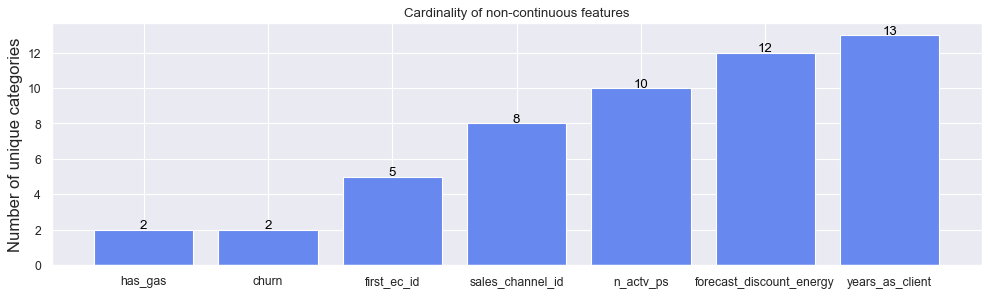

In [33]:
# set palette for binary order 
sns.set_palette([sns.color_palette("coolwarm_r")[5], sns.color_palette("coolwarm_r")[0]])

# Get the number of unique categories for each variable
cat_counts = df_not_continuous.nunique().sort_values()

# Create the bar plot with labels
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.bar(cat_counts.index, cat_counts.values)
ax.set_ylabel('Number of unique categories')
ax.set_xlabel('')
ax.set_title('Cardinality of non-continuous features')

# Add the counts to the top of the bars
for i, v in enumerate(cat_counts.values):
    ax.text(i, v+ 0.05, str(v), ha='center', fontsize=12, color='black')

fig.show();

#### Inspect cardinality of categorical features across classes

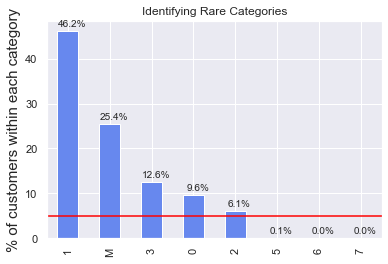

In [34]:
def plot_label_frequency(df, column):
    """Plot the frequency of each label in a categorical variable in a bar chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the categorical variable column.

    Returns:
        None. Displays a bar chart with the frequency of each label in the column.
    """
    # Count the number of occurrences of each label in the column
    label_counts = df[column].value_counts()
    # Calculate the percentage of each label
    label_percentages = (label_counts / label_counts.sum()) * 100
    # Sort the labels by descending percentage
    label_freq = label_percentages.sort_values(ascending=False)

    # Create the bar chart
    fig = label_freq.plot.bar()
    fig.axhline(y=5, color='red')
    fig.set_ylabel('% of customers within each category')
    fig.set_xlabel('')
    fig.set_title('Identifying Rare Categories')

    # Add the percentage labels to the chart
    for i, v in enumerate(label_freq):
        percentage_str = f"{v:.1f}%"
        plt.text(i+0.1, v+1, percentage_str, ha='center')
    return fig

plot_label_frequency(eda,'sales_channel_id');

- Considerar descartar 5, 6 e 7

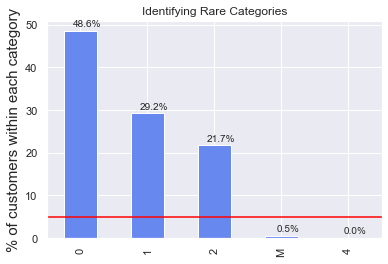

In [35]:
plot_label_frequency(eda,'first_ec_id');

- Considerar descartar M e 4

In [36]:
# Display non-numerical features
eda.select_dtypes(include="datetime").describe()


,date_activ,date_end,date_modif_prod,date_renewal
count,12415,12415,12415,12415
unique,1721,366,2027,376
top,2009-08-01 00:00:00,2016-02-01 00:00:00,2015-11-01 00:00:00,2015-06-23 00:00:00
freq,85,125,609,493
first,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-07-08 00:00:00
last,2014-09-01 00:00:00,2017-06-11 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00


#### Missing values

In [37]:
# Check number of duplicates while ignoring the index feature
n_duplicates = eda.duplicated().sum()
print(f"There is {n_duplicates} duplicates in the dataset.")


There is 0 duplicates in the dataset.


Apenas as variáveis categóricas não binárias possuem valores omissos

In [38]:
eda[['sales_channel_id','first_ec_id']].replace('M', np.nan).isna().mean() * 100

sales_channel_id   25.397
first_ec_id         0.475
dtype: float64

- `sales_channel_id`, tem 25% de NA's. Um número expressivo, exigindo imputação
- `first_ec_id` tem 0.5% de NA's,

#### Duplicates

In [39]:
# Check number of duplicates while ignoring the index feature
n_duplicates = (eda.isna().sum()).sum()
print(f"There is {n_duplicates} columns with missing values in the dataset.")


There is 0 columns with missing values in the dataset.


#### Summary statistics

| Column | Description |
| --- | --- |
| n | The total number of values in the column. |
| nonzero_pct | The percentage of values that are not zero. |
| mean | The arithmetic mean of the values in the column. |
| std | The standard deviation of the values in the column. |
| skewness | A measure of the asymmetry of the distribution of values in the column. |
| min | The minimum value in the column. |
| 1pct | 1th percentile of the values in the column. |
| q1 | The first quartile or 25th percentile of the values in the column. |
| median | 50th percentile of the values in the column. |
| q3 | 75th percentile of the values in the column. |
| 99pct | 99th percentile of the values in the column. |
| max | The maximum value in the column. |

In [40]:
def calculate_stats(df):
    """
    Calculate summary statistics for a pandas DataFrame.
    
    Args:
    df (pandas.DataFrame): Input dataframe
    
    Returns:
    pandas.DataFrame: Dataframe containing summary statistics
    """
    
    # Validate input
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Calculate summary statistics
    summary = (df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
               .transpose()
               .rename(columns={'50%': 'median', 
                                'std': 'std', 
                                'count': 'n',
                                '25%': 'q1', 
                                '75%': 'q3'})
              )
    
    # Add additional statistics
    summary['skewness'] = df.skew()
    summary['nonzero_pct'] = df.astype(bool).mean() * 100
    
    # Reorder and rename columns
    summary = (summary[['n', 'nonzero_pct', 'mean', 'std', 'skewness', 'min', '1%', 'q1', 'median', 'q3', '99%', 'max']]
               .rename(columns=lambda col: col.replace('%', 'pct')))
    
    return summary

eda_num = eda.select_dtypes(exclude=['category', 'datetime', 'int8'])
stats = calculate_stats(eda_num)
stats

,n,nonzero_pct,mean,std,skewness,min,1pct,q1,median,q3,99pct,max
cons_12m,12415.000,99.219,157273.173,562969.684,6.018,0.000,19.280,5628.500,14031.000,40595.000,3118110.000,6207104.000
cons_gas_12m,12415.000,17.865,27631.886,158942.302,9.361,0.000,0.000,0.000,0.000,0.000,867921.000,4154590.000
cons_last_month,12415.000,66.057,15913.807,63705.671,6.501,0.000,0.000,0.000,790.000,3383.500,382647.000,771203.000
forecast_cons_12m,12415.000,97.994,1871.121,2422.344,7.559,0.000,0.000,495.070,1106.200,2399.795,9262.647,82902.830
forecast_cons_year,12415.000,58.123,1377.423,2799.123,7.965,0.000,0.000,0.000,321.000,1752.000,11165.900,79127.000
forecast_discount_energy,12415.000,3.633,1.001,5.193,5.055,0.000,0.000,0.000,0.000,0.000,30.000,30.000
forecast_meter_rent_12m,12415.000,94.917,62.983,66.180,1.534,0.000,0.000,16.180,18.820,131.020,328.740,599.310
forecast_price_e_1,12415.000,99.855,0.137,0.025,-0.078,0.000,0.092,0.116,0.143,0.146,0.211,0.274
forecast_price_e_2,12415.000,51.986,0.051,0.049,-0.016,0.000,0.000,0.000,0.084,0.099,0.131,0.196
forecast_price_p_1,12415.000,99.364,43.125,4.453,-5.071,0.000,40.607,40.607,44.311,44.311,58.996,59.266


Consumption:

The mean consumption for "cons_12m" is quite high at 157,273 kWh, with a very high standard deviation of 562,969 kWh. This indicates a large variation in customer consumption.
The median consumption for "cons_12m" is 14,031 kWh, which is significantly lower than the mean.
The skewness of the "cons_12m" distribution is positive, indicating a long tail towards higher consumption values.
The percentage of non-zero values for "cons_last_month" is 66.06%, indicating that a significant portion of customers have consumed electricity in the past month.
The percentage of non-zero values for "years_as_client" and "n_actv_ps" is 100%, indicating that all customers have been active for at least one year and have at least one active supply point.

Prices:

The mean forecasted price for "forecast_price_p_1" is 43.13 cents/kWh, with a low standard deviation of 4.45 cents/kWh.
The median forecasted price for "forecast_price_p_1" is 44.31 cents/kWh, which is slightly higher than the mean.
The skewness of the "forecast_price_p_1" distribution is negative, indicating a long tail towards lower prices.
The percentage of non-zero values for "forecast_price_e_1" is very high at 99.86%, indicating that almost all customers have a forecasted price for the "tariff_type" E1.
The percentage of non-zero values for "forecast_discount_energy" is low at 3.63%, indicating that most customers do not have a discount on their energy price.

Electricity consumption varies significantly among clients, with the median annual consumption (cons_12m) being 14,031 kWh, but some clients consume as much as 3,118,110 kWh (99th percentile).

Gas consumption is not as widespread as electricity consumption among clients, with only 17.87% of clients having nonzero gas consumption over 12 months.

The majority of clients (66.06%) have consumed electricity in the last month, indicating regular usage.

Forecasted annual consumption (forecast_cons_year) has a median value of 321 kWh, which is considerably lower than the median value for the past 12 months (14,031 kWh). This may suggest that clients are expected to consume less electricity in the coming year.

Clients have a median of 5 years as a customer, and the majority (98.91%) have a margin for both gross and net power.

The price of electricity (price_e) and power (price_p) have different levels of variation across clients, with the standard deviation for price_e_1_mean being 0.022 and for price_p_1_mean being 4.477.

Discounts on energy (forecast_discount_energy) are not very common among clients, with only 3.63% of clients receiving a discount.

##### Skewed features

In [41]:
def find_skewed_features(df, stats_df, skew_thresh=4):
    # Identify the skewed columns
    skewed_columns = (stats_df['skewness'] > skew_thresh) & (stats_df['min'] >= 0)
    return skewed_columns[skewed_columns].index.tolist()

skewed_columns = find_skewed_features(eda_num, stats, skew_thresh=4)    
skewed_columns

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'n_actv_ps',
 'net_margin',
 'pow_max',
 'price_e_1_std',
 'price_e_2_std',
 'price_e_3_std',
 'price_p_1_std',
 'price_p_2_std',
 'price_p_3_std']

In [42]:
stats.T[skewed_columns].T['skewness'].sort_values(ascending=False)

net_margin                 37.487
price_p_1_std              14.836
cons_gas_12m                9.361
n_actv_ps                   9.227
imp_cons                    8.789
forecast_cons_year          7.965
forecast_cons_12m           7.559
cons_last_month             6.501
price_e_1_std               6.375
price_p_3_std               6.068
price_p_2_std               6.037
cons_12m                    6.018
pow_max                     5.700
price_e_3_std               5.687
forecast_discount_energy    5.055
margin_net_pow_ele          4.583
margin_gross_pow_ele        4.582
price_e_2_std               4.253
Name: skewness, dtype: float64

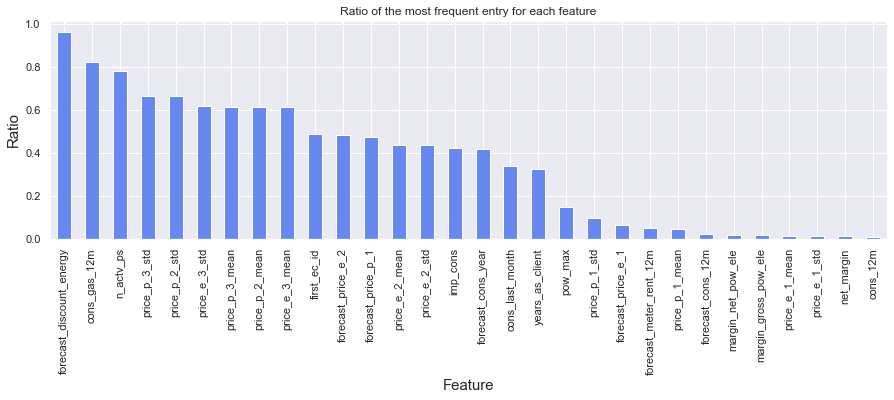

forecast_discount_energy   0.964
cons_gas_12m               0.821
n_actv_ps                  0.781
price_p_3_std              0.665
price_p_2_std              0.665
price_e_3_std              0.618
price_p_3_mean             0.614
price_p_2_mean             0.614
price_e_3_mean             0.613
first_ec_id                0.486
dtype: float64


In [43]:
def plot_most_frequent_entries(df):
    """Plot the ratio of the most frequent entry for each feature in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        None. Displays a bar chart of the ratio of the most frequent entry for each feature.
    """
    # Collect the most frequent entry for each feature
    most_frequent_entry = df.mode()

    # Check if each entry contains the most frequent entry
    df_freq = df.eq(most_frequent_entry.values, axis=1)

    # Compute the mean of the 'is_most_frequent' occurrence
    df_freq = df_freq.mean().sort_values(ascending=False)

    # Plot the ratio of the most frequent entry for each feature
    df_freq.plot.bar(figsize=(15, 4))
    plt.title('Ratio of the most frequent entry for each feature')
    plt.xlabel('Feature')
    plt.ylabel('Ratio')
    plt.show()
    print(df_freq.head(10))

plot_most_frequent_entries(eda_num)   

In [44]:
# Categorizando as features de interesse
cons_cols = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons']
price_cols = ['price_e_1_mean', 'price_e_1_std', 'price_e_2_mean', 'price_e_2_std',
       'price_e_3_mean', 'price_e_3_std', 'price_p_1_mean', 'price_p_1_std',
       'price_p_2_mean', 'price_p_2_std', 'price_p_3_mean', 'price_p_3_std']

client_info_cols = ['has_gas', 'n_actv_ps', 'first_ec_id', 'sales_channel_id', 'forecast_discount_energy']

### Univariate distributions

In [45]:
print(eda[['cons_12m']].describe().to_markdown())

|       |        cons_12m |
|:------|----------------:|
| count |  12415          |
| mean  | 157273          |
| std   | 562970          |
| min   |      0          |
| 25%   |   5628.5        |
| 50%   |  14031          |
| 75%   |  40595          |
| max   |      6.2071e+06 |


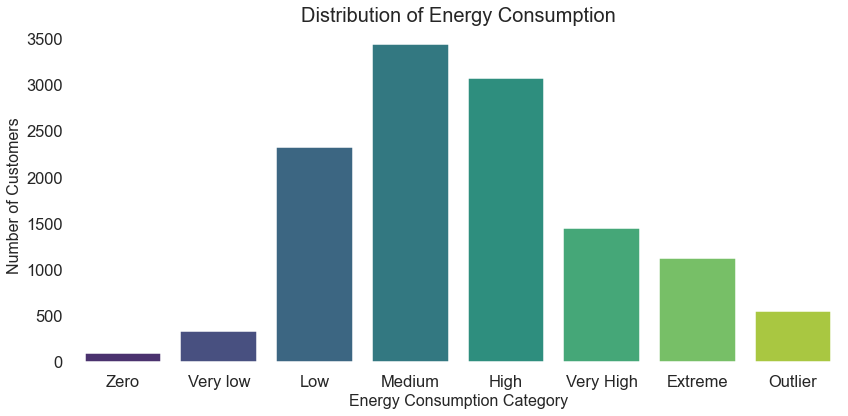

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams.update(
    {"font.size": 14, "figure.facecolor": "w", "axes.facecolor": "w", "axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom": False,
        "xtick.top": False,
        "xtick.bottom": False,
        "ytick.right": False,
        "ytick.left": False,
     }
)

# Assuming you have the 'cons_12m' data stored in a DataFrame called 'data'
bins = [-np.inf, 0, 1000, 5000, 14000, 40000, 100000, 1000000, np.inf]  # Define the bin boundaries
labels = ['Zero', 'Very low', 'Low', 'Medium', 'High', 'Very High', 'Extreme', 'Outlier']  # Labels for each bin category

# Perform binning based on custom categories
cons_12m_category = pd.cut(eda['cons_12m'], bins=bins, labels=labels, right=False)
cons_12m_category = cons_12m_category.where(eda['cons_12m'] != 0, 'Zero')

# Count the number of values in each bin
counts = cons_12m_category.value_counts().sort_index()

# Create a new figure
plt.figure(figsize=(12, 6))
# Create bar plot with seaborn
sns.barplot(x=counts.index, y=counts, palette="viridis")

# Add title and axis labels
plt.title('Distribution of Energy Consumption', size=20)
plt.xlabel('Energy Consumption Category', size=16)
plt.ylabel('Number of Customers', size=16)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('output.png', dpi=300)

In [25]:
cons_12m_category

0              Low
1              Low
2           Medium
3              Low
4             High
           ...    
12410         High
12411          Low
12412          Low
12413       Medium
12414    Very High
Name: cons_12m, Length: 12415, dtype: category
Categories (8, object): ['Zero' < 'Very low' < 'Low' < 'Medium' < 'High' < 'Very High' < 'Extreme' < 'Outlier']

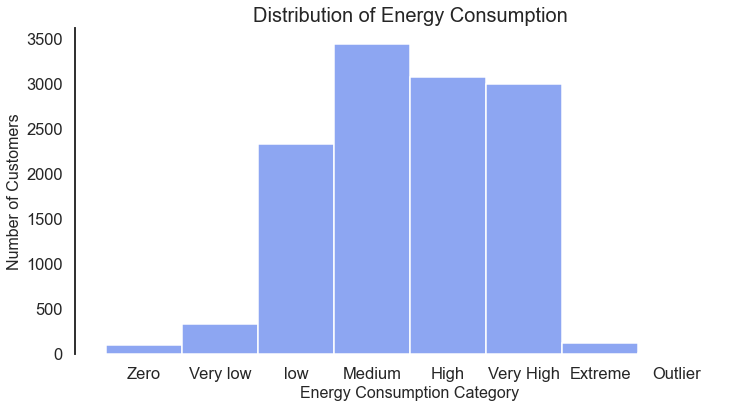

<Figure size 432x288 with 0 Axes>

In [62]:
np.set_printoptions(suppress=True)
# Assuming you have the 'cons_12m' data stored in a DataFrame called 'data'
bins = [-np.inf, 0, 1000, 5000, 14000, 40000, 3000000, 6000000, np.inf]  # Define the bin boundaries
labels = ['Zero', 'Very low', 'low', 'Medium', 'High', 'Very High', 'Extreme', 'Outlier']  # Labels for each bin category# Perform binning based on custom categories
cons_12m_category = pd.cut(eda['cons_12m'], bins=bins, labels=labels, right=False)
cons_12m_category = cons_12m_category.where(eda['cons_12m'] != 0, 'Zero')
cons_12m_category.value_counts().sort_index()

# Create a new figure
plt.figure(figsize=(12, 6))
sns.histplot(data=cons_12m_category)
# Add title and axis labels
# Add title and axis labels
plt.title('Distribution of Energy Consumption', size=20)
plt.xlabel('Energy Consumption Category', size=16)
plt.ylabel('Number of Customers', size=16)

plt.show()
plt.tight_layout()

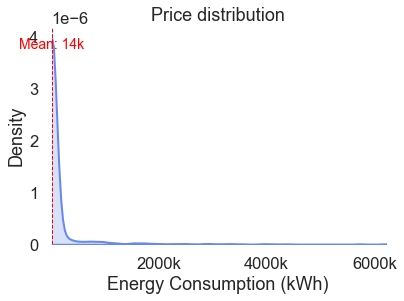

In [81]:
import matplotlib.ticker as ticker

#sns.set_style("white")
sns.kdeplot(data=eda, x='cons_12m', fill=True, linewidth=2, bw_adjust=1, levels=30)
# Suppress scientific notation in axis tick labels
plt.ticklabel_format(style='plain', axis='x')

# Create a custom formatter for the axis tick labels
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k')

# Add a vertical line at the mean value
mean_value = eda['cons_12m'].median()
plt.axvline(mean_value, color='red', linestyle='--', linewidth=1)
plt.text(mean_value, plt.ylim()[1]*0.9, f'Mean: {int(mean_value/1000)}k', color='red', ha='center')

# Apply the custom formatter to the x-axis tick labels
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(1, eda['cons_12m'].max())
# Add title and axis labels
plt.title('Price distribution')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Density')
plt.show()

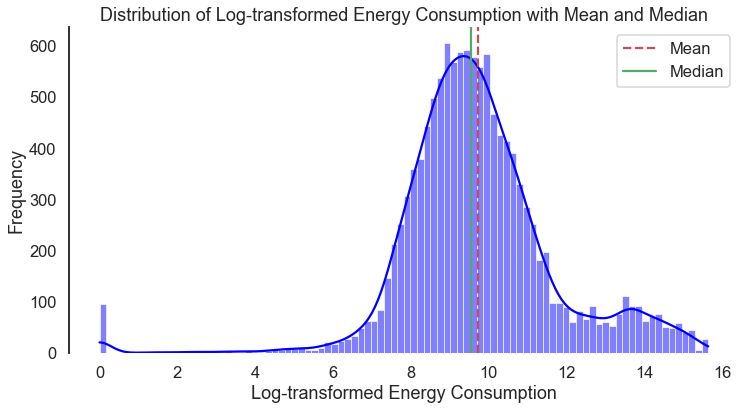

In [64]:
plt.figure(figsize=(12, 6))
log_cons = np.log1p(eda['cons_12m'])
sns.histplot(log_cons, kde=True, color='blue')
plt.axvline(x=np.mean(log_cons), color='r', linestyle='--', label='Mean')
plt.axvline(x=np.median(log_cons), color='g', linestyle='-', label='Median')
plt.legend()
plt.title('Distribution of Log-transformed Energy Consumption with Mean and Median')
plt.xlabel('Log-transformed Energy Consumption')
plt.ylabel('Frequency')
plt.show()


#### Numeric

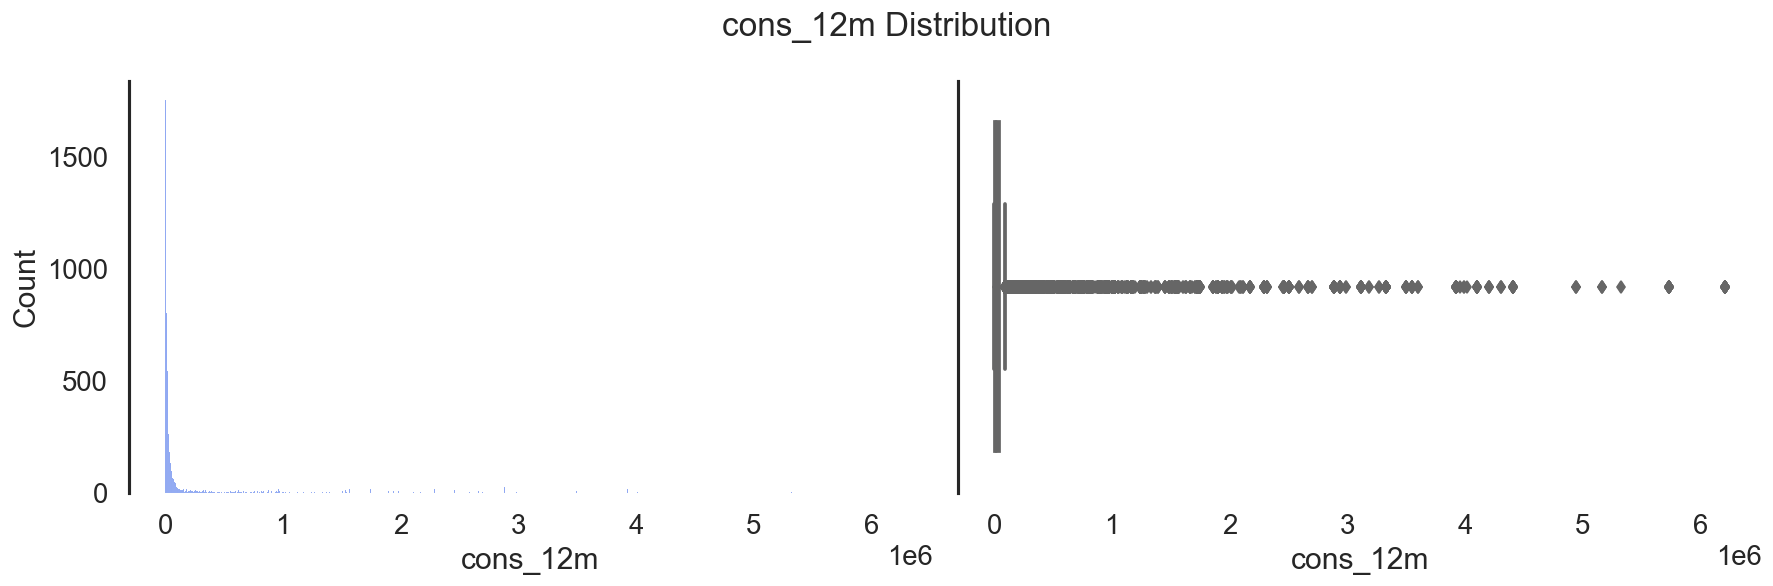

In [65]:
def get_num_dist(df, column, transform=False):
    """Plot the distribution and boxplot of a numerical variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the numerical variable column.
        transform (bool, optional): Whether to transform the data using np.log1p(). Default is False.

    Returns:
        None. Displays a histogram and boxplot of the numerical variable.
    """
    # Create a copy of the DataFrame with the selected column
    data = df[[column]].copy()

    # Transform the data using np.log1p() if requested
    if transform:
        data[column] = np.log1p(data[column])

    # Create subplots for the distribution and boxplot
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)

    # Plot the distribution using a histogram
    sns.histplot(x=column, data=data, ax=ax[0])
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Count')

    # Plot the distribution using a boxplot
    sns.boxplot(x=column, data=data, ax=ax[1])
    ax[1].set_xlabel(column)

    # Set the title of the figure
    plt.suptitle(f'{column} Distribution', fontsize=20)

    # Adjust the layout and display the figure
    plt.tight_layout()
    plt.show()

get_num_dist(eda, 'cons_12m', transform=False)

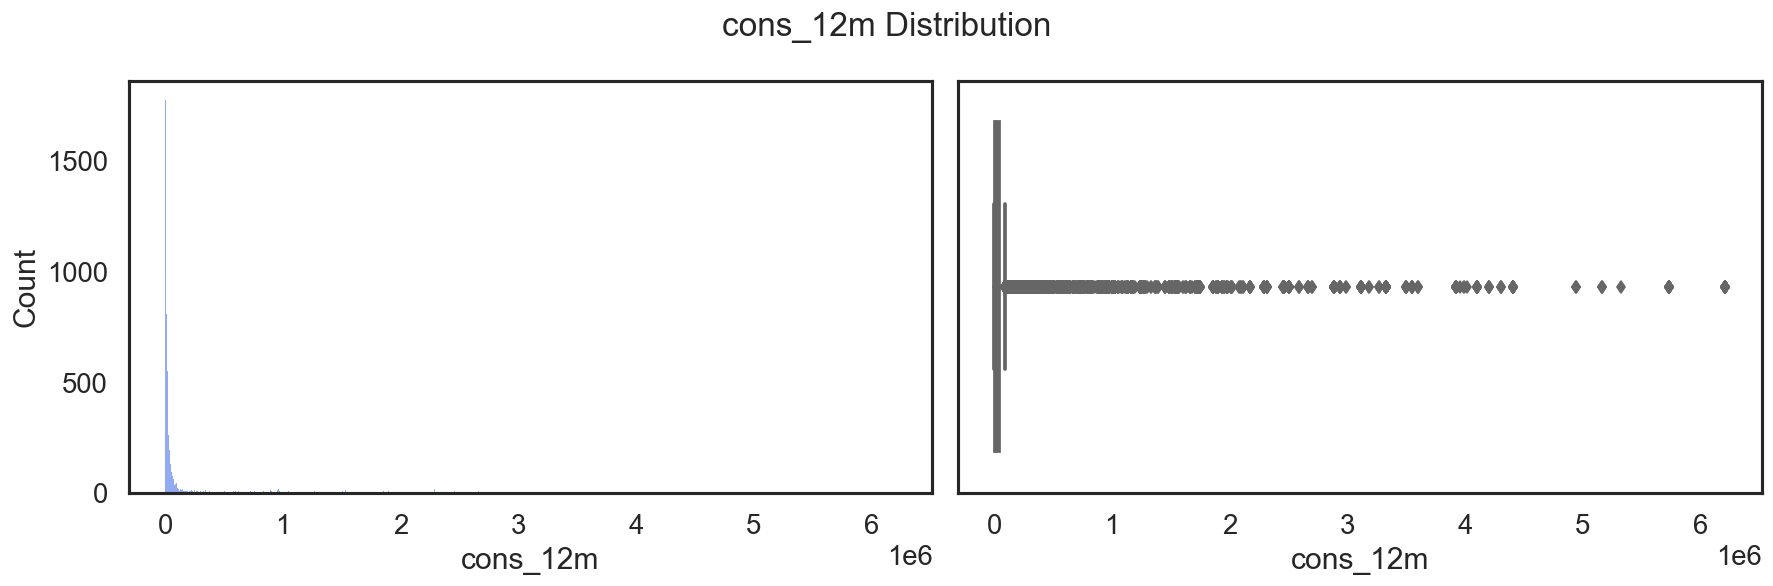

In [56]:
get_num_dist(eda.query('cons_12m > 0'), 'cons_12m', transform=False)

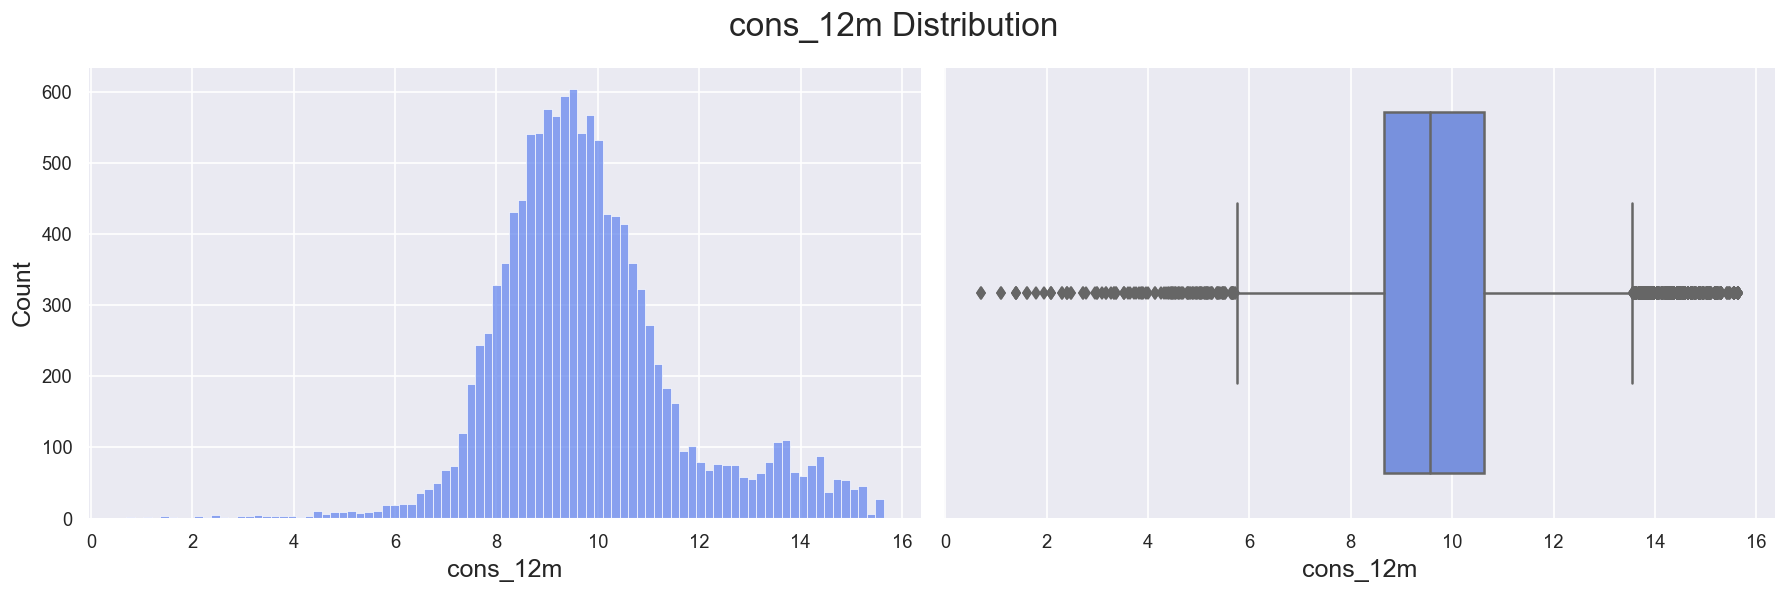

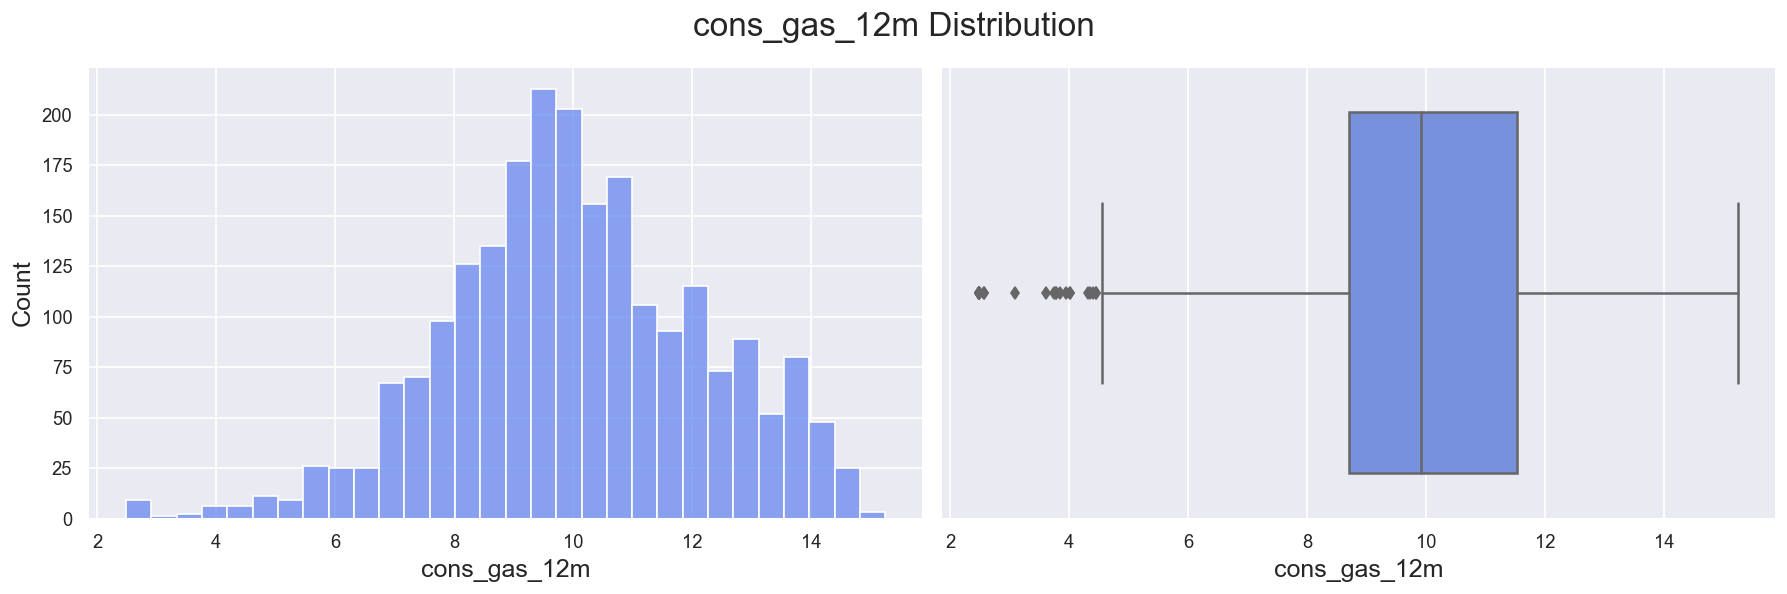

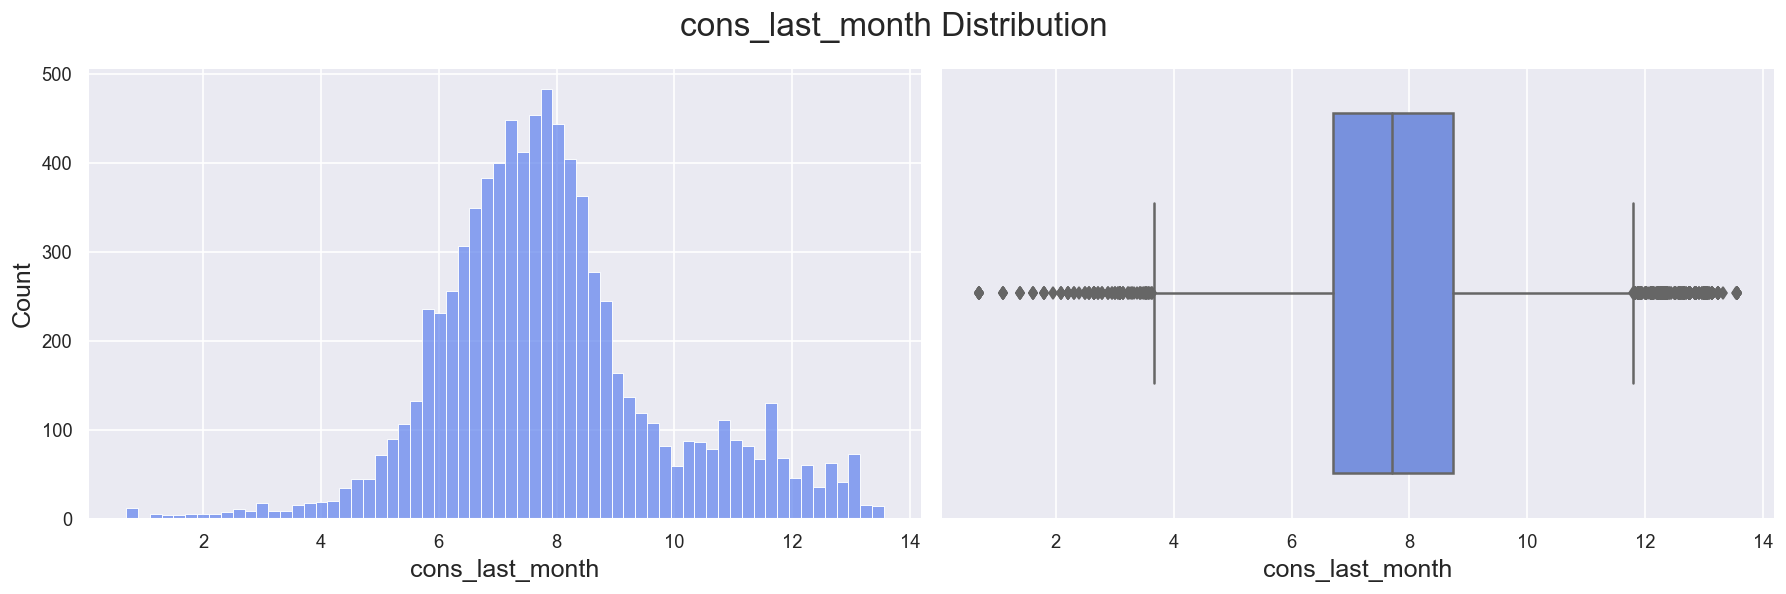

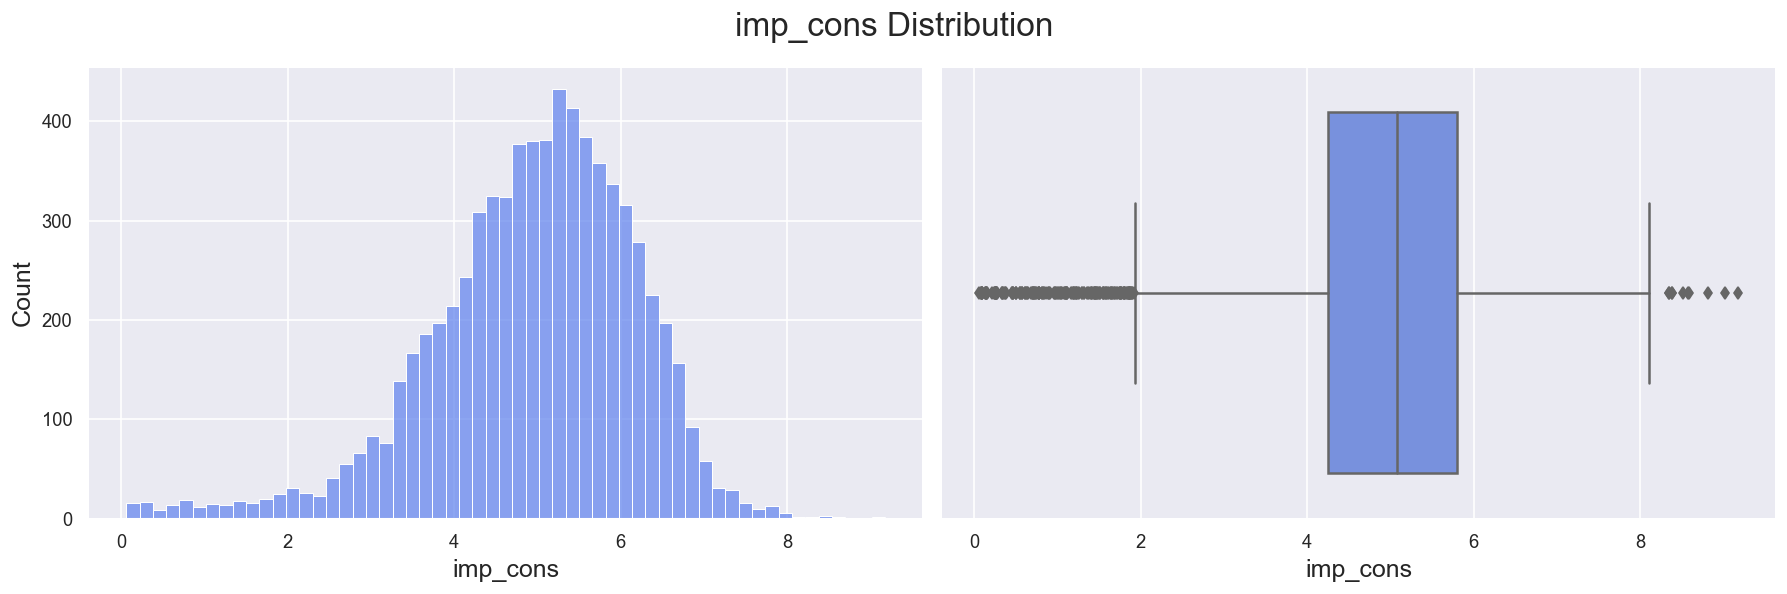

In [ ]:
for col in cons_cols:
    get_num_dist(eda.query(f'{col}>0'), col, transform=True)

In [57]:
price_mean_cols = eda.filter(like='_mean').columns.tolist()
price_std_cols = eda.filter(like='_std').columns.tolist()

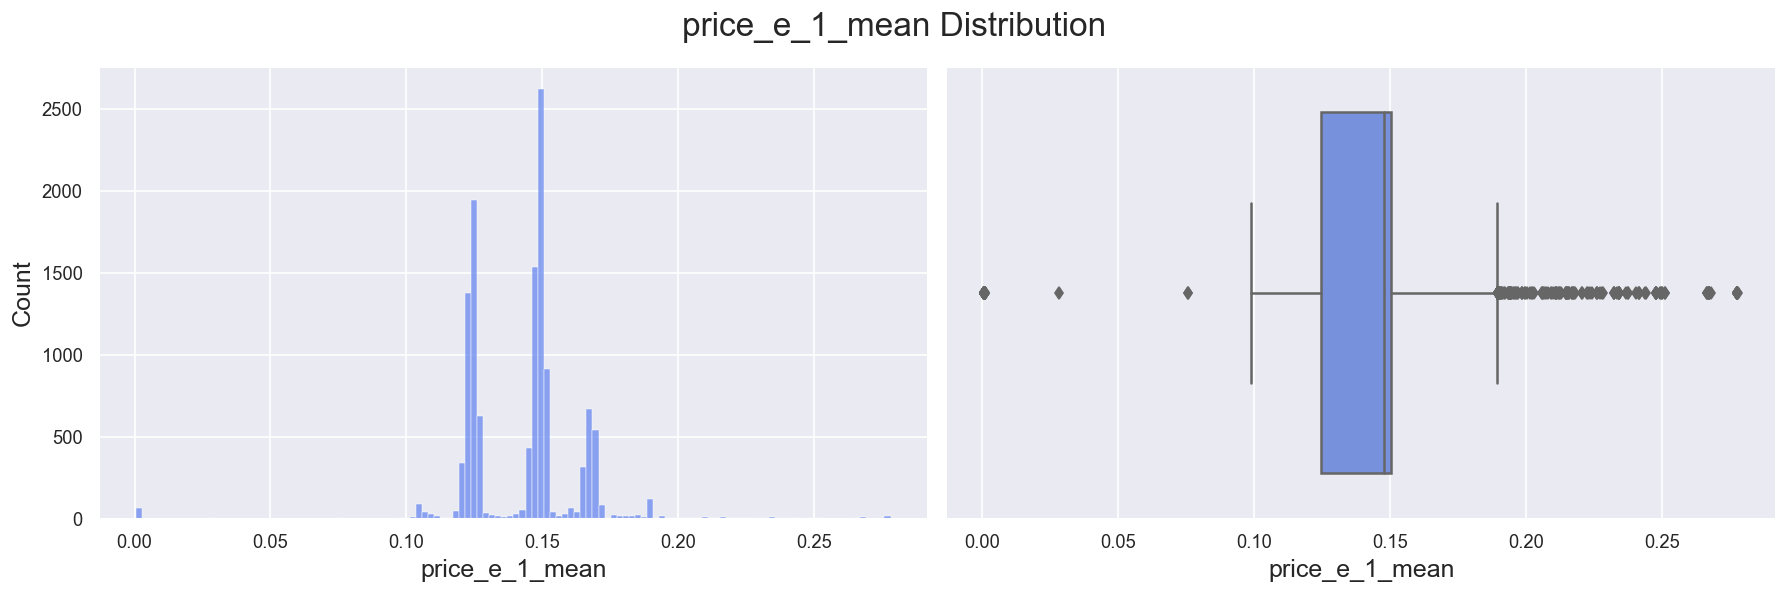

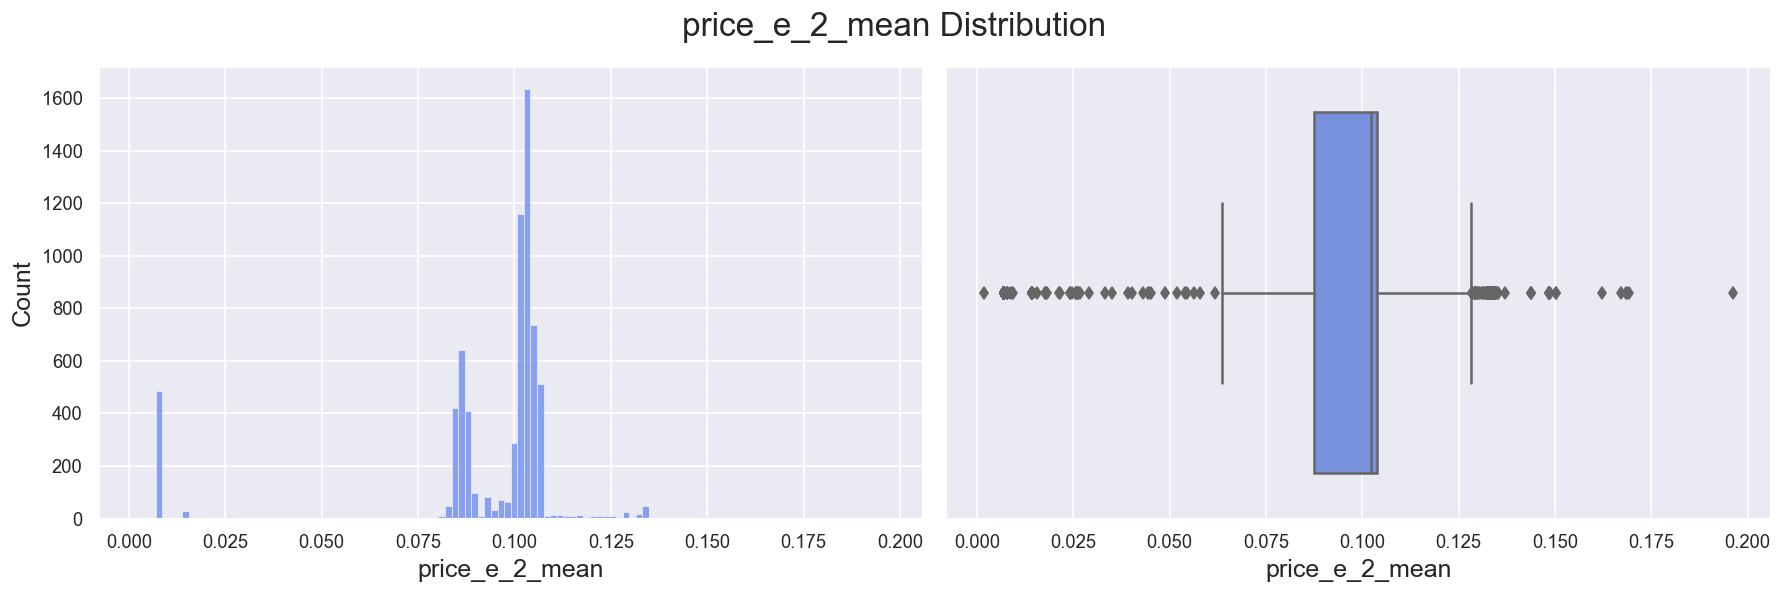

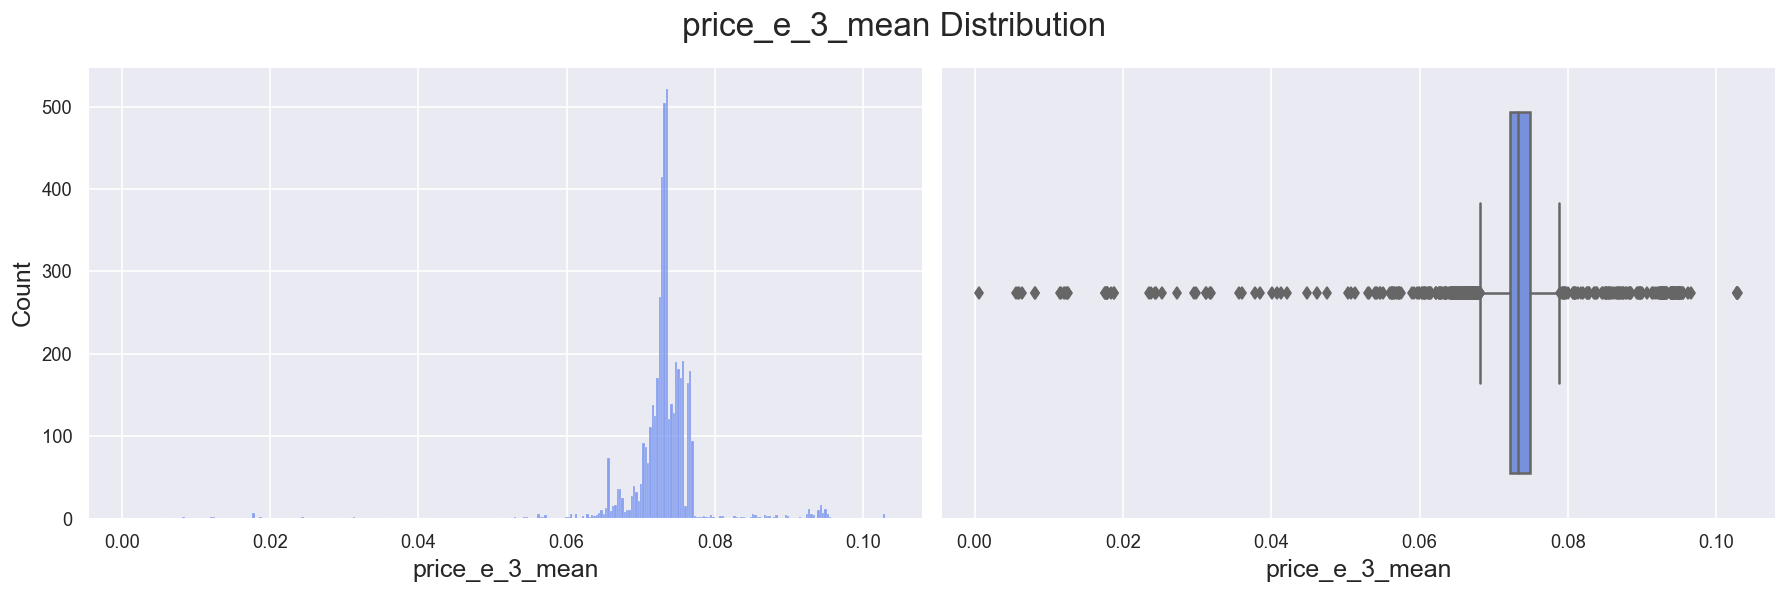

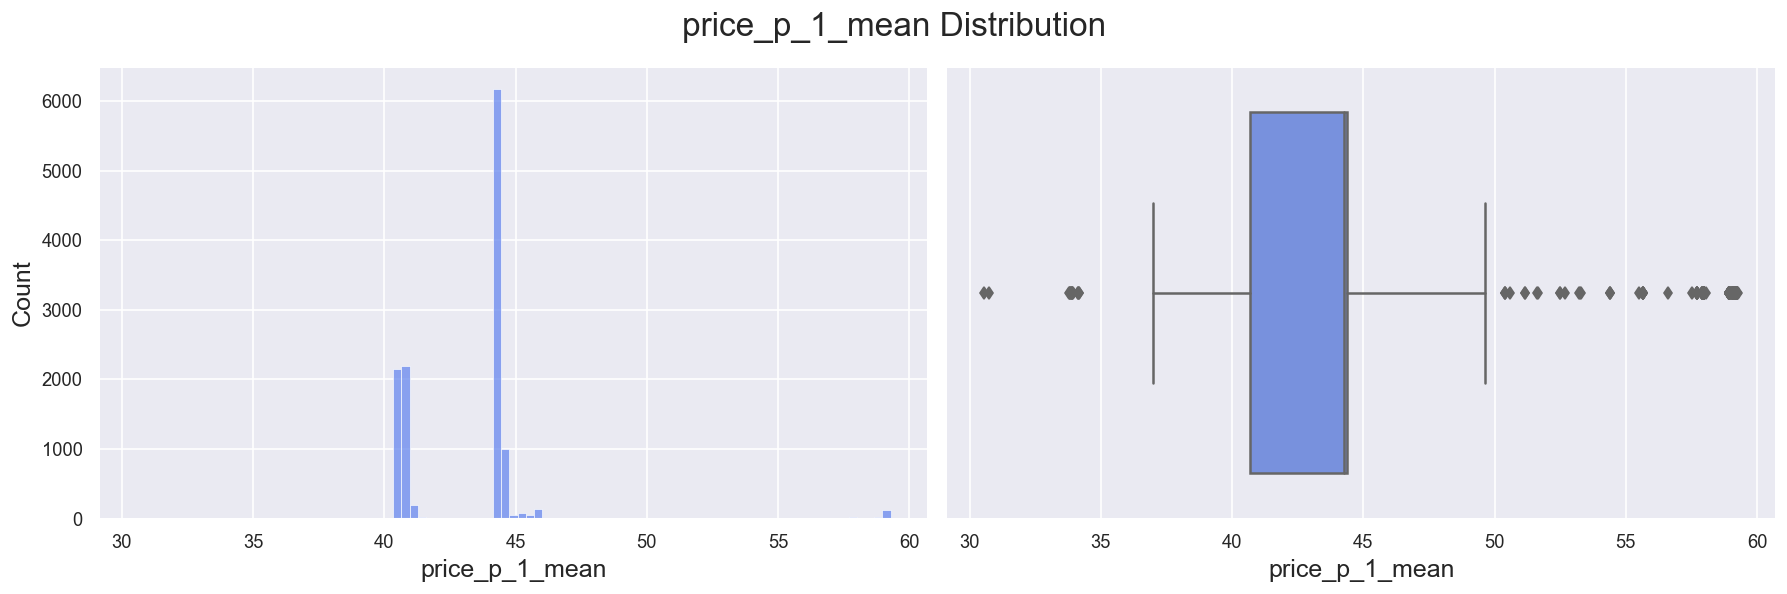

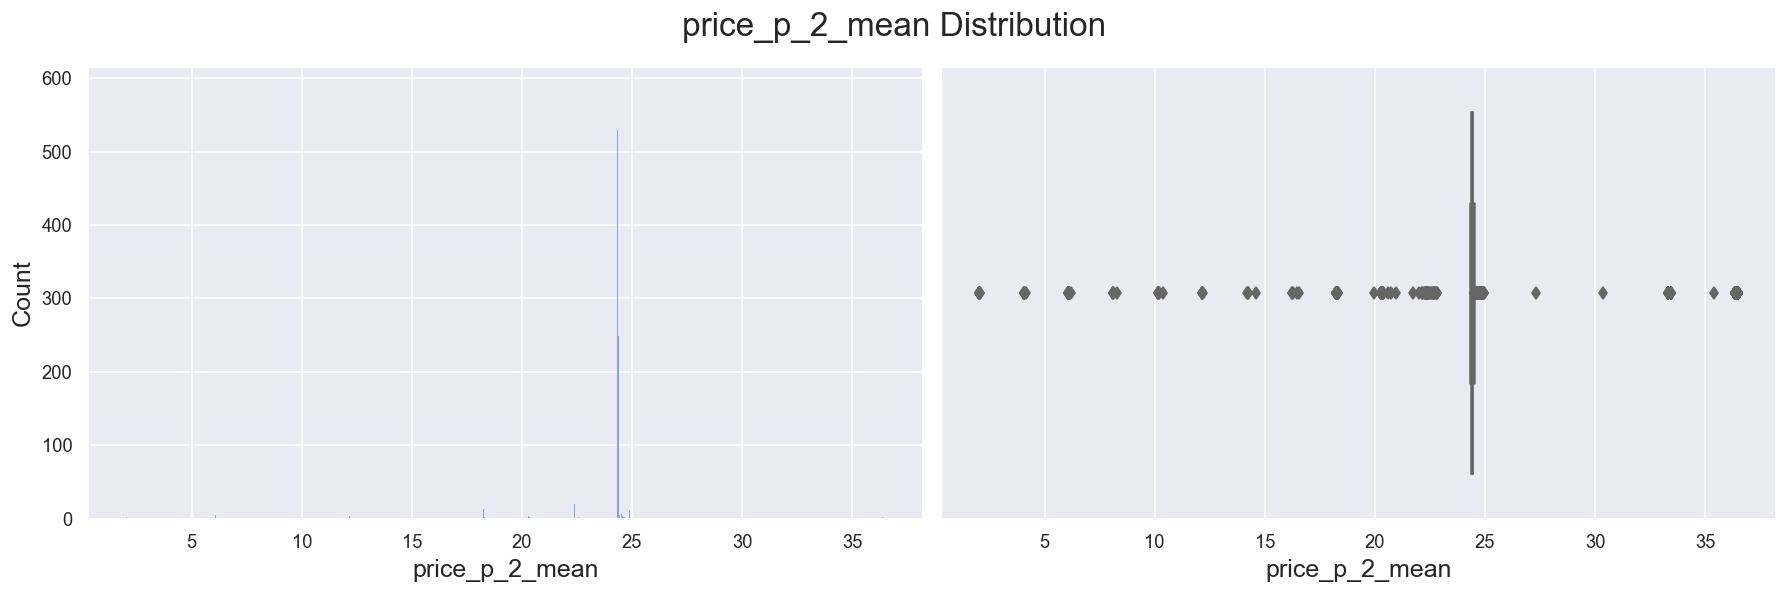

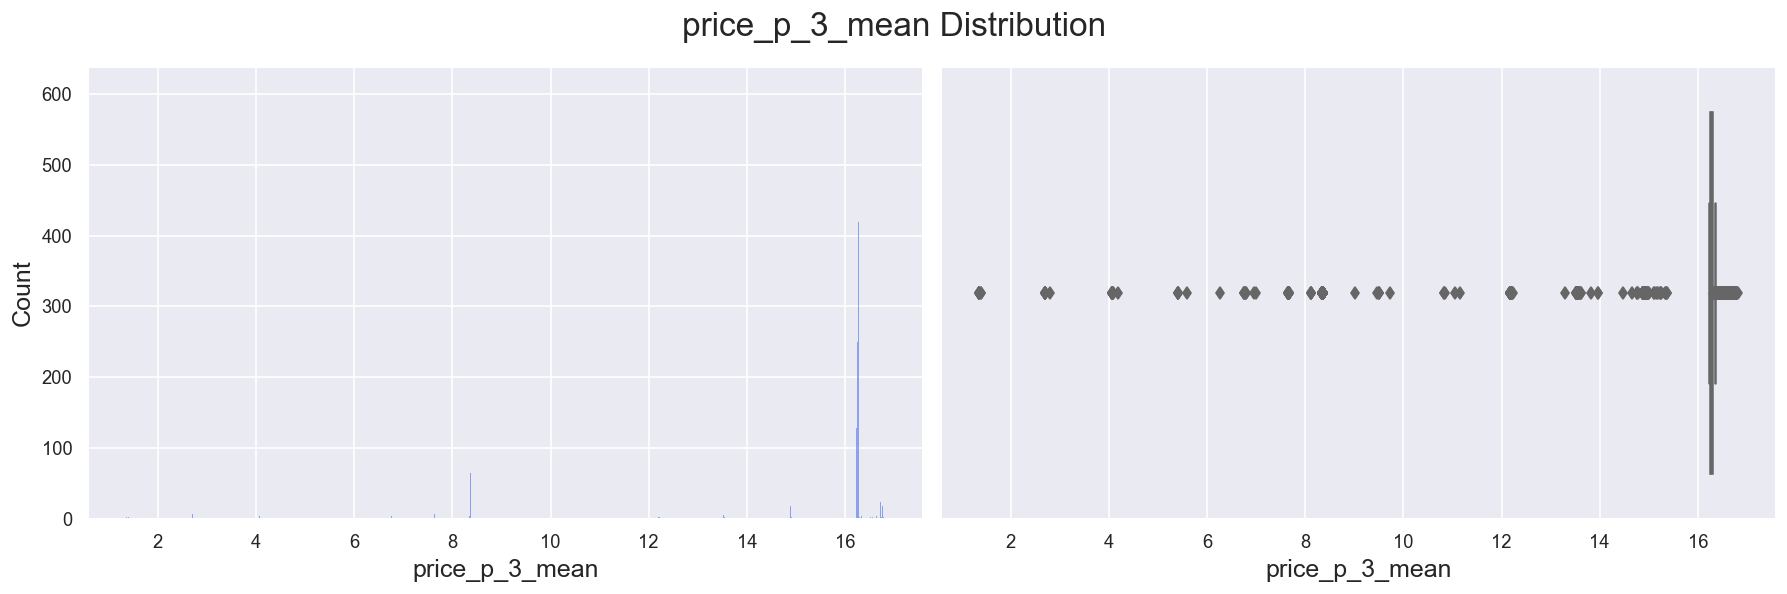

In [ ]:
for col in price_mean_cols:
    get_num_dist(eda.query(f'{col}>0'), col, transform=False)

#### Non-Numeric

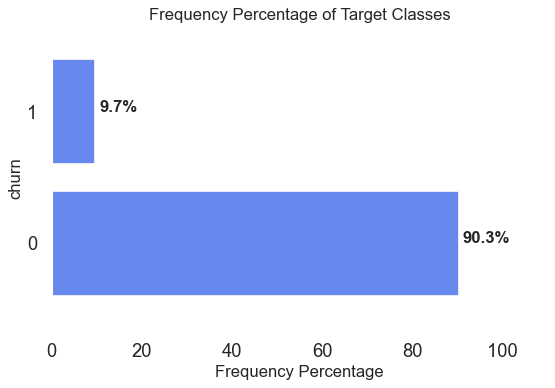

In [83]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
eda['churn'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = eda['churn'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i] +0.9, i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xticks(rotation=0)
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('churn', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

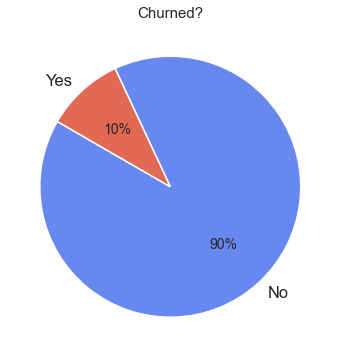

In [88]:
import matplotlib.pyplot as plt
# Create a new figure
plt.figure(figsize=(6, 6))

# Calculate churn percentages
churn_counts = eda['churn'].value_counts(normalize=True).mul(100)
churn_labels = ['No', 'Yes']

# Set colors for the pie chart
#colors = ['grey', 'red']

# Create the pie chart
plt.pie(churn_counts, labels=churn_labels, autopct='%1.0f%%', #colors=colors,
         startangle=150)

# Add a title
plt.title('Churned?', fontsize=15)

# Display the pie chart
plt.savefig('churn.png', dpi=300)


Given that 9.71% of customers churn, it is essential for energy companies to address the factors contributing to customer attrition. As our analysis has shown, price sensitivity is a significant factor influencing customer churn and consumption patterns. By focusing on maintaining competitive prices and avoiding large fluctuations during off-peak and mid-peak hours, energy companies can improve customer satisfaction, reduce churn rates, and retain more customers in the long run. Implementing strategies such as targeted marketing campaigns, personalized offers, and improved customer service can also help companies connect with their customers and address their concerns, further reducing the likelihood of churn.

In [59]:
train.churn.mean()*100

9.714055577929924

In [ ]:

# Create a new figure
plt.figure(figsize=(12, 6))
# Create bar plot with seaborn
sns.barplot(x=counts.index, y=counts, palette="viridis")

# Add title and axis labels
plt.title('Distribution of Energy Consumption', size=20)
plt.xlabel('Energy Consumption Category', size=16)
plt.ylabel('Number of Customers', size=16)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('output.png', dpi=300)

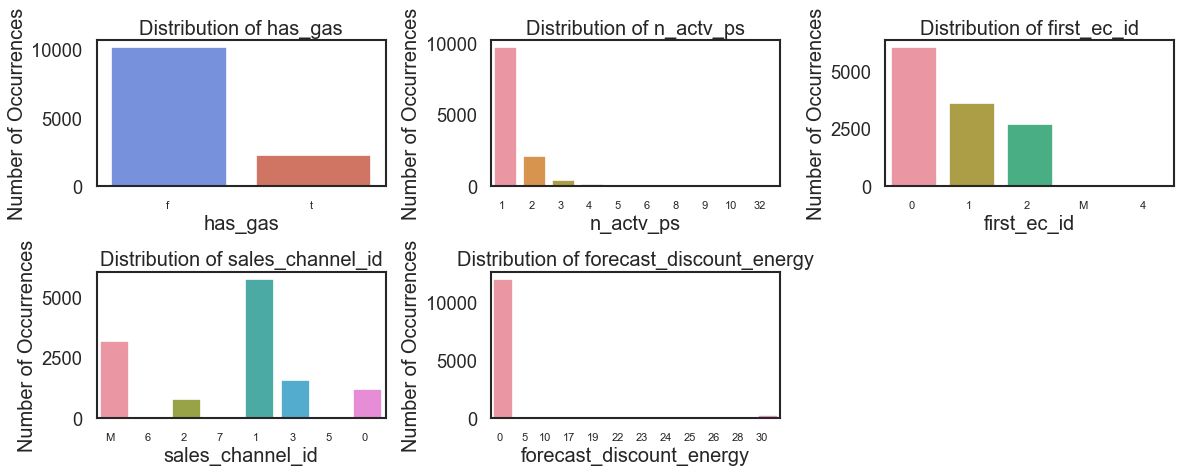

In [60]:
def plot_countplots(df, columns, figsize=(15, 6), fontsize=10):
    """
    Creates count plots for multiple columns in a DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to create count plots for.
        figsize (tuple, optional): The size of the figure. Defaults to (10, 6).
        fontsize (int, optional): The font size of the x-axis tick labels. Defaults to 10.
        
    Returns:
        None. Displays the count plots for the specified columns.
    """
    # Calculate the number of rows and columns for the subplots
    n_cols = min(len(columns), 3)
    n_rows = int(len(columns) / n_cols) + int(len(columns) % n_cols > 0)

    # Create the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=80)

    # Flatten the subplots array
    axes = axes.flatten()

    # Loop over the columns and create a count plot for each one
    for i, col in enumerate(columns):
        # Create the count plot
        sns.countplot(data=df, x=col, ax=axes[i])

        # Set the y-axis label and title
        axes[i].set_ylabel('Number of Occurrences')
        axes[i].set_title('Distribution of ' + col)

        # Rotate the x-axis tick labels to avoid overlap
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha='right')

        # Reduce the font size of the x-axis tick labels
        for tick in axes[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize)

    # Hide any extra subplots
    for i in range(len(columns), len(axes)):
        axes[i].axis('off')

    # Adjust the layout and display the figure
    plt.tight_layout()
    plt.show()

plot_countplots(eda, client_info_cols)    

- 82% dos clientes não usam gas
- 78% dos clientes usam apenas 1 produto
- 50% dos clientes se inscreveram inicialmente na campanha 0
- 46% dos clientes estão no canal de vendas 1, equanto 5,6,7 não tem nenhum
- 96% dos clientes não ganharam descontos, com 2% ganhando 30%

In [ ]:
round(eda['forecast_discount_energy'].value_counts(normalize=True).sort_values(ascending=False) * 100)

0    96.000
30    2.000
28    1.000
24    1.000
22    0.000
25    0.000
26    0.000
17    0.000
19    0.000
23    0.000
10    0.000
5     0.000
Name: forecast_discount_energy, dtype: float64

### Bivariate

In [109]:
stats_churned = calculate_stats(eda.query('churn==1').filter(regex='cons|margin'))
stats_churned

,n,nonzero_pct,mean,std,skewness,min,1pct,q1,median,q3,99pct,max
cons_12m,1206.00,99.42,75968.18,256289.00,8.07,0.00,45.05,5658.25,13751.00,39516.25,1139164.65,3955941.00
cons_gas_12m,1206.00,15.75,9810.30,52613.04,8.55,0.00,0.00,0.00,0.00,0.00,280354.00,828344.00
cons_last_month,1206.00,67.41,6969.32,26715.70,8.81,0.00,0.00,0.00,713.50,2934.50,116664.00,448776.00
forecast_cons_12m,1206.00,98.76,1942.29,2857.85,9.38,0.00,0.00,489.06,1103.66,2441.92,9286.86,61357.17
forecast_cons_year,1206.00,59.87,1314.31,2547.72,5.73,0.00,0.00,0.00,333.50,1647.00,10488.35,37891.00
imp_cons,1206.00,60.03,147.35,288.35,5.59,0.00,0.00,0.00,42.34,180.98,1206.92,4205.64
margin_gross_pow_ele,1206.00,98.18,30.68,26.06,3.88,0.00,0.00,17.62,26.04,34.68,155.44,299.64
margin_net_pow_ele,1206.00,98.18,30.68,26.06,3.88,0.00,0.00,17.62,26.04,34.68,155.44,299.64
net_margin,1206.00,98.84,228.50,753.61,28.22,0.00,0.00,51.05,119.56,264.20,1224.84,24570.65


In [106]:
eda.query('churn==1')['cons_12m'].median()

13751.0

In [111]:
eda.query('churn==0')['cons_12m'].median()

14046.0

In [107]:
eda.query('churn==1')['cons_last_month'].median()

713.5

In [112]:
eda['years_as_client'].median()

5.0

In [110]:
eda.query('churn==1')['years_as_client'].median()

4.0

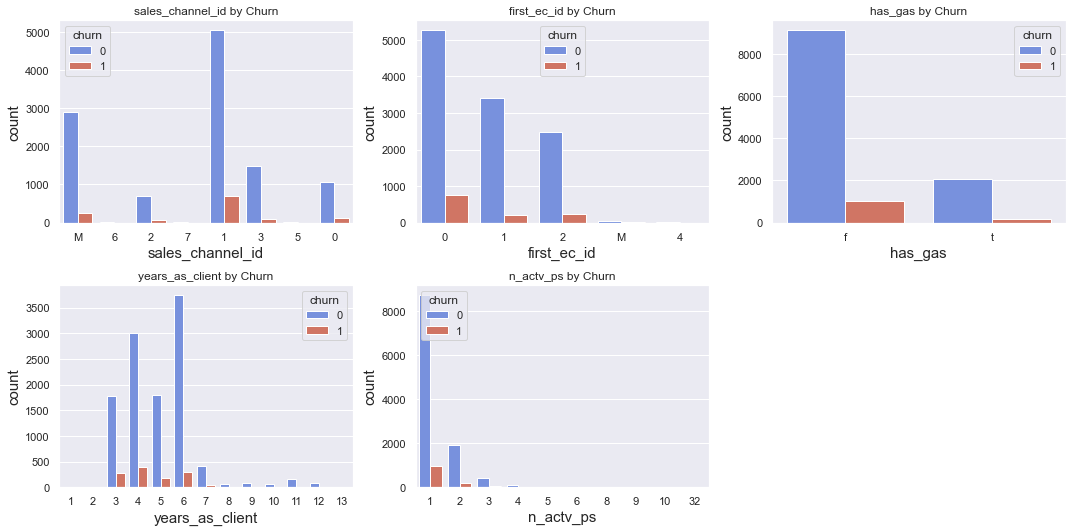

In [ ]:
# set palette for binary order 
sns.set_palette([sns.color_palette("coolwarm_r")[5], sns.color_palette("coolwarm_r")[0]])

columns_to_visualize = eda[cat_cols+['years_as_client']+['n_actv_ps']].columns.tolist()

# Set the size of the plots
plt.figure(figsize=(15, len(columns_to_visualize) * 1.5))

# Calculate the number of rows and columns for the grid
n_rows = math.ceil(len(columns_to_visualize) / 3)
n_cols = 3

# Loop through the columns to visualize
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(n_rows, n_cols, i)  # Set up subplots with the specified number of rows and columns
    sns.countplot(data=eda, hue="churn", x=column)
    plt.title(f'{column} by Churn')

# Adjust the layout to prevent overlapping plots
plt.tight_layout()

# Show the plots
plt.show()

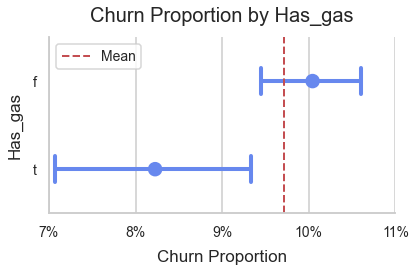

In [170]:
def plot_churn_proportion(df, x_column, y_column, error_arg=('ci', 95)):
   
   
    sns.pointplot(data=df, y=y_column, x=x_column, orient='h', join=False, capsize=.3, errorbar=error_arg, markers='o', scale=1.1)

    mean_churn_proportion = df[x_column].mean()
    
    plt.axvline(mean_churn_proportion, color='r', linestyle='--', lw=2, label="Mean")
    #plt.legend(loc='upper right')
    plt.legend(fontsize=14)
    plt.title(f"Churn Proportion by {y_column.capitalize()}", fontsize=20, pad=15)
    plt.ylabel(y_column.capitalize(), fontsize=17, labelpad=10)
    plt.xlabel("Churn Proportion", fontsize=17, labelpad=10)
    plt.xticks(fontsize=14)
    plt.xlim(0.07, 0.11)
    plt.yticks(fontsize=14)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    sns.despine()
    plt.tight_layout()
    #plt.xticks(np.arange(0, 0.3, 0.1), rotation=0)
    plt.show()

plot_churn_proportion(eda,'churn', 'has_gas')    

In [ ]:
eda.groupby('sales_channel_id')['churn'].mean().round(2)

sales_channel_id
M   0.080
6   0.000
2   0.080
7   0.000
1   0.120
3   0.050
5   0.000
0   0.100
Name: churn, dtype: float64

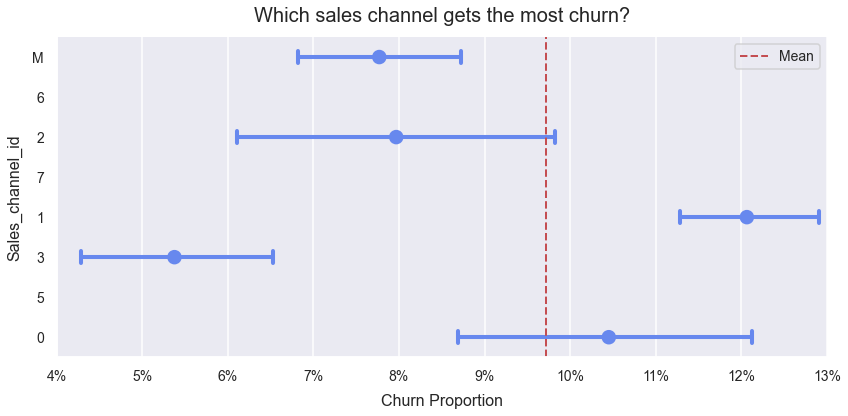

In [178]:
from matplotlib.ticker import FuncFormatter

def plot_churn_proportion(df, x_column, y_column, error_arg=('ci', 95), save_fig=True):
    with sns.axes_style("darkgrid"):
        # Create a new figure
        plt.figure(figsize=(12, 6))
        sns.pointplot(data=df, y=y_column, x=x_column, orient='h', join=False, capsize=.3, errorbar=error_arg, markers='o', scale=1.1)

        mean_churn_proportion = df[x_column].mean()
        
        plt.axvline(mean_churn_proportion, color='r', linestyle='--', lw=2, label="Mean")
        plt.legend(fontsize=14)
        plt.title(f"Which sales channel gets the most churn?", fontsize=20, pad=15)
        plt.ylabel(y_column.capitalize(), fontsize=16, labelpad=10)
        plt.xlabel("Churn Proportion", fontsize=16, labelpad=10)
        plt.xlim(0.04, 0.13)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.0%}'))
        sns.despine()
        plt.tight_layout()
        if save_fig:
            plt.savefig('churn_proportion.png', dpi=300)
        plt.show()


plot_churn_proportion(eda,'churn', 'sales_channel_id')    


- Most customers who left were from sales channel 1, with a churn rate above the general average.

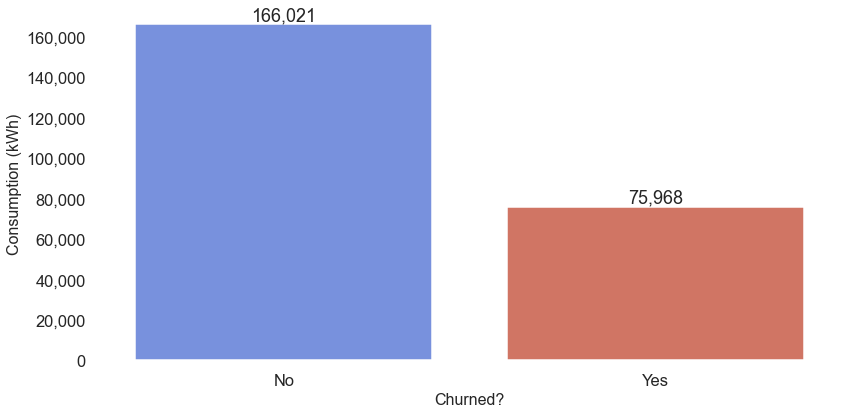

In [71]:
import matplotlib.ticker as ticker
# set palette for binary order 
sns.set_palette([sns.color_palette("coolwarm_r")[5], sns.color_palette("coolwarm_r")[0]])
plt.figure(figsize=(12, 6))
# Create bar plot with seaborn
ax = sns.barplot(data=eda,x="churn", y="cons_12m",  ci=None)

# Add title and axis labels
plt.title('', size=20)
plt.xlabel('Churned?', size=16)
plt.ylabel('Consumption (kWh)', size=16)



# Calculate mean values for each category
means = eda.groupby('churn')['cons_12m'].mean().values

# Add mean values on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(format(means[i], ',.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', size=18)

# Format y-axis labels with thousands separator
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Change x-axis tick labels
ax.set_xticklabels(['No', 'Yes'])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.savefig('cons_churned.png', dpi=300)

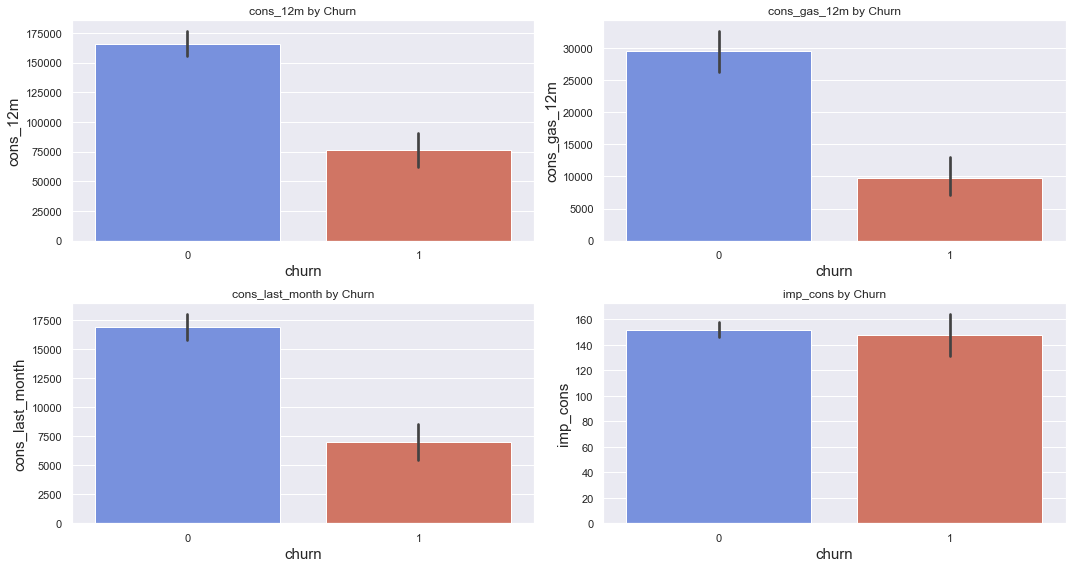

In [ ]:
columns_to_visualize = eda[cons_cols].columns.tolist()

# Set the size of the plots
plt.figure(figsize=(15, len(columns_to_visualize) * 2))

# Calculate the number of rows and columns for the grid
n_rows = math.ceil(len(columns_to_visualize) / 3)
n_cols = 2

# Loop through the columns to visualize
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(n_rows, n_cols, i)  # Set up subplots with the specified number of rows and columns
    sns.barplot(data=eda, x="churn", y=column)
    plt.title(f'{column} by Churn')

# Adjust the layout to prevent overlapping plots
plt.tight_layout()

# Show the plots
plt.show()

- Customers who left seem to have consumed less energy

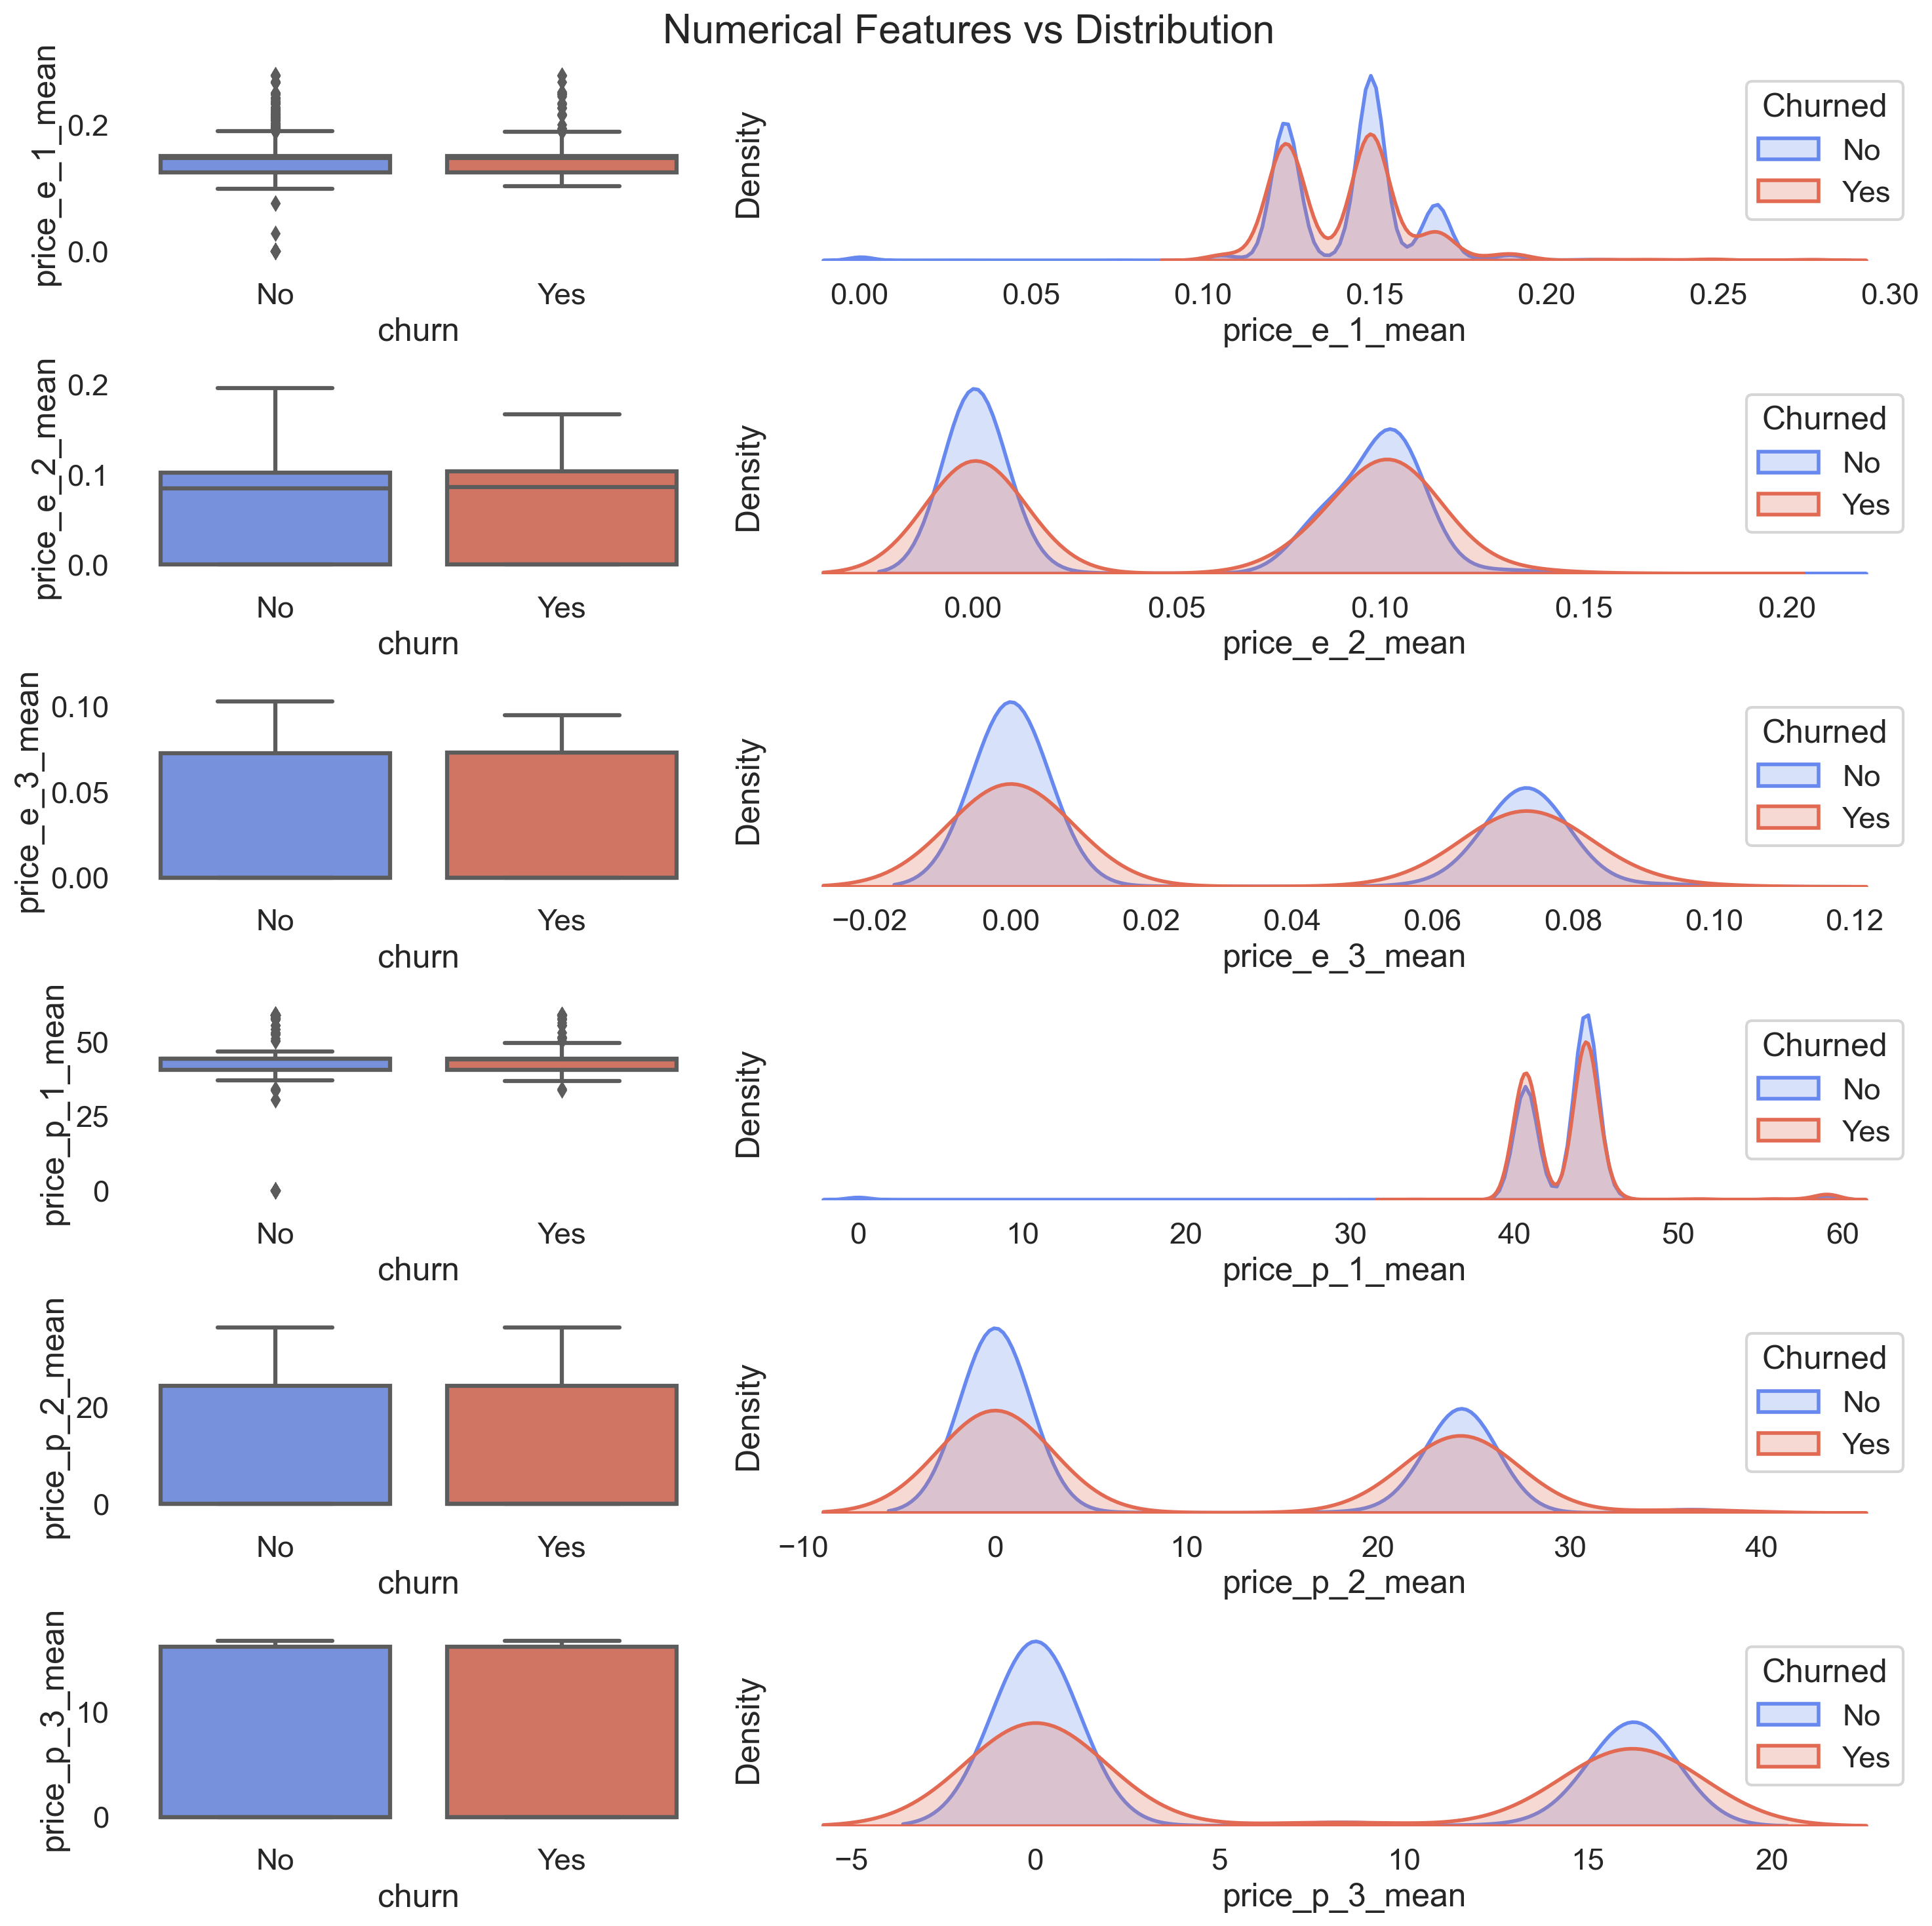

In [91]:
price_mean_cols = eda.filter(like="mean").columns.tolist()

def plot_num_dist(df, columns, transform=False):
    """Plot the distribution and boxplot of a numerical variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the numerical variable column.
        transform (bool, optional): Whether to transform the data using np.log1p(). Default is False.

    Returns:
        None. Displays a histogram and boxplot of the numerical variable.
    """
    # Create a copy of the DataFrame with the selected column
    data = df[columns+['churn']].copy()

    # Transform the data using np.log1p() if requested
    if transform:
        for col in columns:
            data[col] = np.log1p(data[col])


    fig, ax = plt.subplots(len(columns), 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

    for i, col in enumerate(columns):
        # barplot
        graph = sns.boxplot(data=data, x='churn', y=col, ax=ax[i,0])
        ax[i,0].set_xticks([0,1],['No', 'Yes'])
        # kde Plot
        sns.kdeplot(data=data[data['churn']==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='No')
        sns.kdeplot(data=data[data['churn']==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='Yes')
        ax[i,1].set_yticks([])
        ax[i,1].legend(title='Churned', loc='upper right')
        # Add bar sizes to our plot
        for cont in graph.containers:
            graph.bar_label(cont, fmt='         ,.0f')
            
    plt.suptitle('Numerical Features vs Distribution', fontsize=22)
    plt.tight_layout()                     
    plt.show()
plot_num_dist(eda, price_mean_cols, transform=False)    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1 - Distribution plot 1
sns.distplot(eda['column1'], ax=axes[0])
axes[0].set_title('Distribution Plot 1')

# Plot 2 - Distribution plot 2
sns.distplot(eda['column2'], ax=axes[1])
axes[1].set_title('Distribution Plot 2')

# Plot 3 - Distribution plot 3
sns.distplot(eda['column3'], ax=axes[2])
axes[2].set_title('Distribution Plot 3')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [89]:
eda.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_e_1,forecast_price_e_2,forecast_price_p_1,...,price_e_2_mean,price_e_2_std,price_e_3_mean,price_e_3_std,price_p_1_mean,price_p_1_std,price_p_2_mean,price_p_2_std,price_p_3_mean,price_p_3_std
count,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,...,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00,12415.00
mean,157273.17,27631.89,15913.81,1871.12,1377.42,1.00,62.98,0.14,0.05,43.13,...,0.05,0.00,0.03,0.00,42.93,0.19,9.44,0.26,6.10,0.17
std,562969.68,158942.30,63705.67,2422.34,2799.12,5.19,66.18,0.02,0.05,4.45,...,0.05,0.01,0.04,0.00,4.48,0.83,12.03,1.43,7.77,0.93
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5628.50,0.00,0.00,495.07,0.00,0.00,16.18,0.12,0.00,40.61,...,0.00,0.00,0.00,0.00,40.69,0.00,0.00,0.00,0.00,0.00
50%,14031.00,0.00,790.00,1106.20,321.00,0.00,18.82,0.14,0.08,44.31,...,0.08,0.00,0.00,0.00,44.28,0.08,0.00,0.00,0.00,0.00
75%,40595.00,0.00,3383.50,2399.80,1752.00,0.00,131.02,0.15,0.10,44.31,...,0.10,0.00,0.07,0.00,44.37,0.09,24.37,0.04,16.25,0.03
max,6207104.00,4154590.00,771203.00,82902.83,79127.00,30.00,599.31,0.27,0.20,59.27,...,0.20,0.07,0.10,0.05,59.29,18.56,36.49,16.47,16.82,8.65


Among the customers who left, none had their price equal to zero

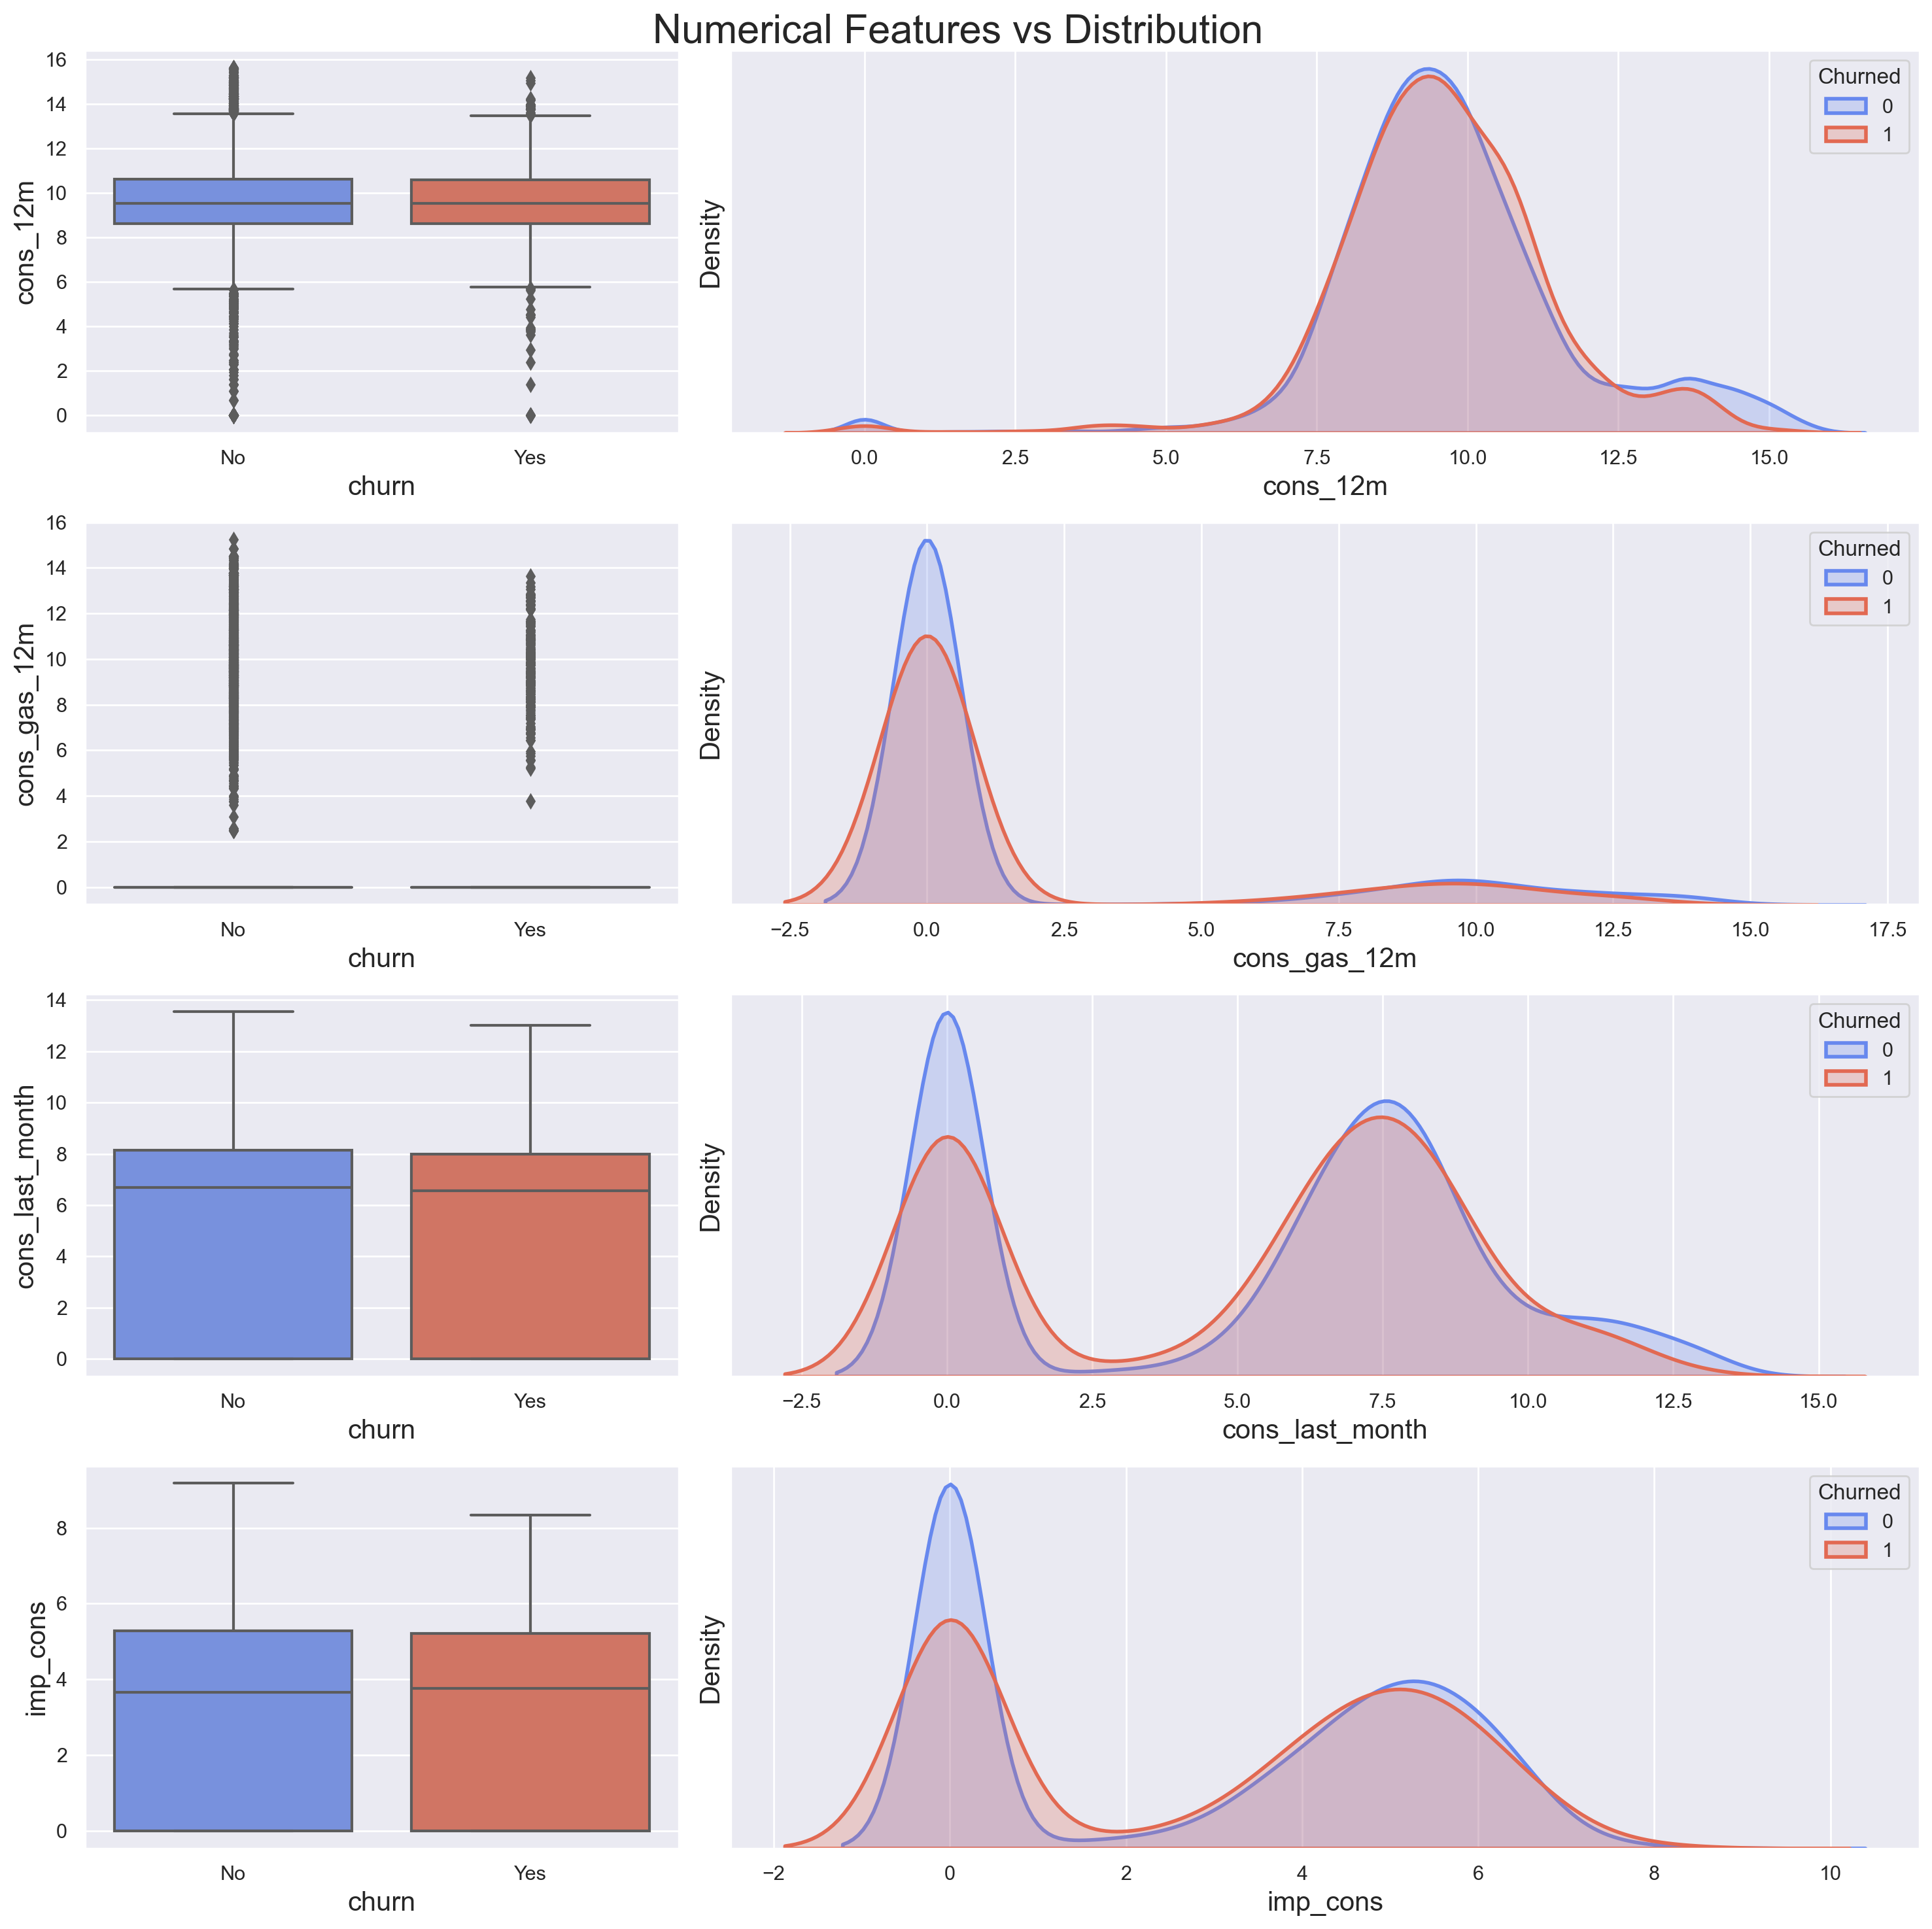

In [ ]:
plot_num_dist(eda, cons_cols, transform=True)    

### Multivariate

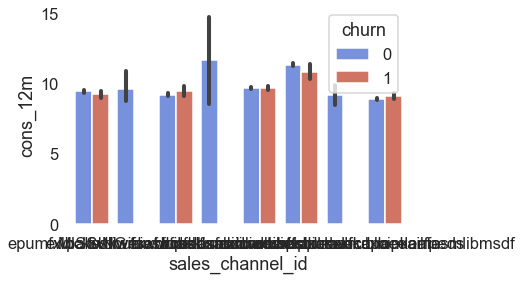

In [75]:
# Entre os clientes que receberam desconto, qual deles houve maior saída de clientes?
sns.barplot(data=eda, x="sales_channel_id", y=np.log1p(eda["cons_12m"]), hue="churn")
plt.show()

#### Correlation

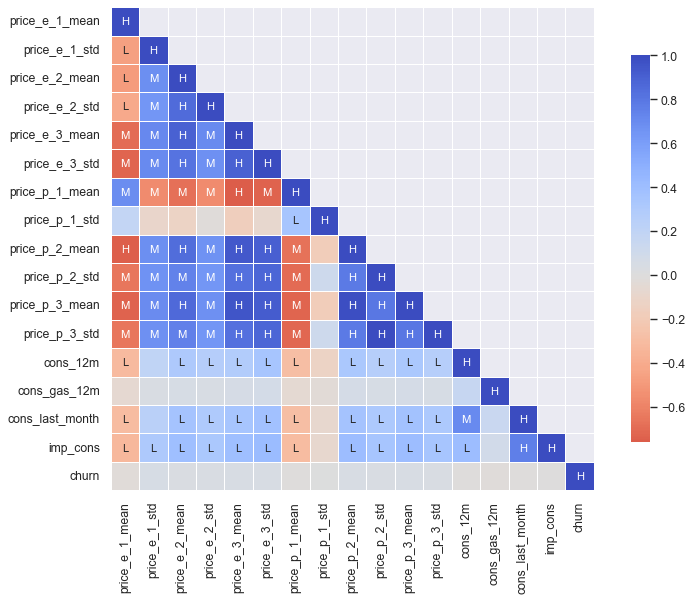

In [ ]:
# Computes feature correlation
df_corr = eda[price_cols+cons_cols+target].corr(method='spearman')


# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "L", "")))


mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot correlation matrix
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(df_corr, mask=mask, square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap='coolwarm_r', cbar_kws={"shrink": 0.8});


These correlation coefficients indicate that there is a weak relationship between the different energy prices and the churn rate. The positive correlations imply that as energy prices increase, there is a slight tendency for the churn rate to increase as well. However, the overall correlation is weak, so the relationship between energy prices and churn is not very strong. This suggests that price sensitivity may not be the primary factor influencing customer churn in this dataset.

### Price elasticty of demand


In [ ]:
from statsmodels.formula.api import rlm
# Fit the robust regression model
huber_model = rlm('np.log1p(cons_12m) ~ np.log1p(price_e_1_mean) + np.log1p(price_e_2_mean) + np.log1p(price_e_3_mean)', data=train, M=sm.robust.norms.HuberT()).fit()
# Print the model summary
print(huber_model.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:     np.log1p(cons_12m)   No. Observations:                12415
Model:                            RLM   Df Residuals:                    12411
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 10 May 2023                                         
Time:                        11:33:30                                         
No. Iterations:                    19                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

There is a significant negative relationship between the log1p-transformed price_e_1_mean and log1p-transformed consumption. This implies that as the price of energy product 1 increases by 1% (approximately), the consumption decreases by about 9.57% (approximately). This indicates that the demand for energy product 1 is somewhat elastic, and consumers may reduce their consumption of this product when its price increases.

There is a significant positive relationship between the log1p-transformed price_e_2_mean and log1p-transformed consumption. This suggests that as the price of energy product 2 increases by 1% (approximately), the consumption increases by about 10.52% (approximately). This unusual positive relationship may be due to a variety of reasons, such as consumers perceiving higher-priced energy product 2 as being of higher quality or substituting energy product 2 for other products when its price increases. Further analysis is needed to understand this relationship better.

The relationship between the log1p-transformed price_e_3_mean and log1p-transformed consumption is not statistically significant. This indicates that changes in the price of energy product 3 do not have a significant impact on consumption. It is possible that the demand for energy product 3 is relatively inelastic, or that other factors are more important in determining its consumption.

#### Churned

In [ ]:
# Separate the data into churned and non-churned customers
churned = eda[eda['churn'] == 1]
non_churned = eda[eda['churn'] == 0]

In [ ]:
model_churned = smf.rlm('np.log1p(cons_12m) ~ np.log1p(price_e_1_mean) + np.log1p(price_e_2_mean) + np.log1p(price_e_3_mean)', data=churned).fit()
print("Log-Log Regression for Churned Customers:")
print(model_churned.summary())

Log-Log Regression for Churned Customers:
                    Robust linear Model Regression Results                    
Dep. Variable:     np.log1p(cons_12m)   No. Observations:                 1206
Model:                            RLM   Df Residuals:                     1202
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 10 May 2023                                         
Time:                        11:33:30                                         
No. Iterations:                    16                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

There is a significant negative relationship between the log1p-transformed price_e_1_mean and log1p-transformed consumption. As the price of energy product 1 increases by 1% (approximately), the consumption decreases by about 16.05% (approximately). This indicates that the demand for energy product 1 is elastic among churned customers, and they may reduce their consumption of this product when its price increases.

There is a significant positive relationship between the log1p-transformed price_e_2_mean and log1p-transformed consumption. This suggests that as the price of energy product 2 increases by 1% (approximately), the consumption increases by about 5.14% (approximately) among churned customers. This positive relationship may be due to a variety of reasons, such as churned customers perceiving higher-priced energy product 2 as being of higher quality or substituting energy product 2 for other products when its price increases.

The relationship between the log1p-transformed price_e_3_mean and log1p-transformed consumption is not statistically significant for churned customers. This indicates that changes in the price of energy product 3 do not have a significant impact on consumption for this group of customers. It is possible that the demand for energy product 3 is relatively inelastic, or that other factors are more important in determining its consumption.

#### Non-churned

In [ ]:
model_non_churned = smf.rlm('np.log1p(cons_12m) ~ np.log1p(price_e_1_mean) + np.log1p(price_e_2_mean) + np.log1p(price_e_3_mean)', data=non_churned).fit()
print("Log-Log Regression for Non-Churned Customers:")
print(model_non_churned.summary())

Log-Log Regression for Non-Churned Customers:
                    Robust linear Model Regression Results                    
Dep. Variable:     np.log1p(cons_12m)   No. Observations:                11209
Model:                            RLM   Df Residuals:                    11205
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 10 May 2023                                         
Time:                        11:33:31                                         
No. Iterations:                    19                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

There is a significant negative relationship between the log1p-transformed price_e_1_mean and log1p-transformed consumption. As the price of energy product 1 increases by 1% (approximately), the consumption decreases by about 9.28% (approximately) among non-churned customers. This indicates that the demand for energy product 1 is elastic among non-churned customers, and they may also reduce their consumption of this product when its price increases.

There is a significant positive relationship between the log1p-transformed price_e_2_mean and log1p-transformed consumption. This suggests that as the price of energy product 2 increases by 1% (approximately), the consumption increases by about 11.04% (approximately) among non-churned customers. Similar to churned customers, this unusual positive relationship may be due to a variety of reasons, such as non-churned customers perceiving higher-priced energy product 2 as being of higher quality or substituting energy product 2 for other products when its price increases.

The relationship between the log1p-transformed price_e_3_mean and log1p-transformed consumption is not statistically significant for non-churned customers. This indicates that changes in the price of energy product 3 do not have a significant impact on consumption for this group of customers, similar to churned customers. It is possible that the demand for energy product 3 is relatively inelastic, or that other factors are more important in determining its consumption.

### Conclusion

Both churned and non-churned customers have similar patterns in their consumption behavior with respect to energy product prices. The demand for energy product 1 is elastic for both groups, while the demand for energy product 3 is relatively inelastic. The positive relationship between the price of energy product 2 and consumption is unusual and may require further investigation to understand the underlying reasons.

In conclusion, our analysis reveals valuable insights into how price sensitivity affects consumption and churn in the energy market, taking into account different periods: off-peak (energy product 1), peak (energy product 2), and mid-peak (energy product 3). We have uncovered that the demand for energy during the off-peak period is elastic for both churned and non-churned customers, suggesting that they are highly sensitive to price changes during this period. On the other hand, the demand for energy during the mid-peak period is relatively inelastic, implying that customers are not significantly affected by its price fluctuations.

One surprising finding is the positive relationship between the peak period energy price and consumption for both groups. This unusual behavior indicates that customers may be willing to pay a premium for energy during peak hours, perhaps due to the perceived benefits or the necessity of using energy during this time.

### Feature Importance

[14:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


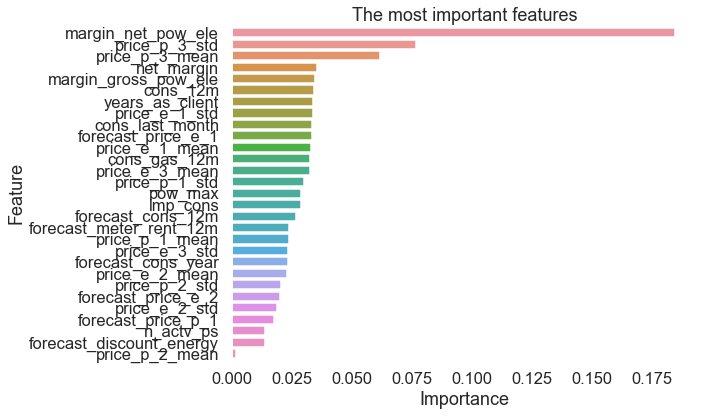

In [27]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

selected_cols = train.select_dtypes(exclude=['object','datetime', 'category','int8']).columns
X_train, y_train = train[selected_cols], train[['churn']]
X_test, y_test = test[selected_cols], test[['churn']]
model = XGBClassifier(scale_pos_weight=10, importance_type = "cover")
model.fit(X_train, y_train)

# Extract the feature importances from the fitted XGBoost model
importance = model.feature_importances_

# Create a pandas dataframe to store the feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})

# Sort the features by their importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the feature importances using seaborn
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('The most important features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [37]:
print(feature_importance_df.head(10).reset_index(drop=True).to_markdown())

|    | Feature              |   Importance |
|---:|:---------------------|-------------:|
|  0 | margin_net_pow_ele   |     1        |
|  1 | price_p_3_std        |     0.411244 |
|  2 | price_p_3_mean       |     0.328294 |
|  3 | net_margin           |     0.186195 |
|  4 | margin_gross_pow_ele |     0.181761 |
|  5 | cons_12m             |     0.179266 |
|  6 | years_as_client      |     0.17515  |
|  7 | price_e_1_std        |     0.175065 |
|  8 | cons_last_month      |     0.174186 |
|  9 | forecast_price_e_1   |     0.172985 |


In [41]:
feature_importance_df.head(10).Feature.values

array(['margin_net_pow_ele', 'price_p_3_std', 'price_p_3_mean',
       'net_margin', 'margin_gross_pow_ele', 'cons_12m',
       'years_as_client', 'price_e_1_std', 'cons_last_month',
       'forecast_price_e_1'], dtype=object)

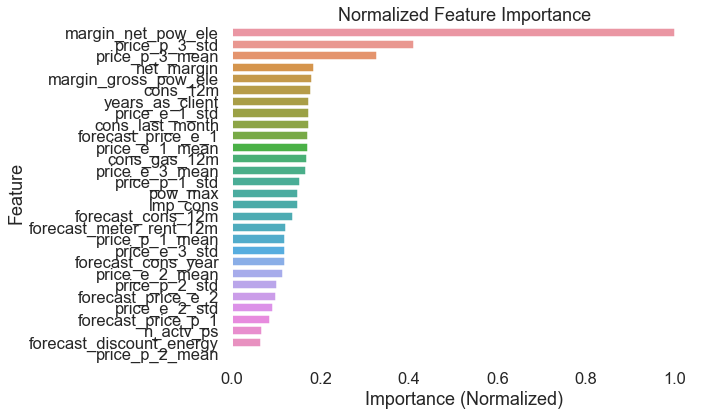

In [29]:
# Extract the feature importances from the fitted XGBoost model
importance = model.feature_importances_

# Perform Min-Max scaling to normalize the feature importances
importance_normalized = (importance - importance.min()) / (importance.max() - importance.min())

# Create a pandas DataFrame to store the feature names and their normalized importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_normalized})

# Sort the features by their importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the normalized feature importances using a horizontal bar plot
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=ax)

# Set the title and axis labels
ax.set_title('Normalized Feature Importance')
ax.set_xlabel('Importance (Normalized)')
ax.set_ylabel('Feature')

# Improve the spacing and layout
plt.tight_layout()

# Display the plot
plt.show()


Taking into account the updated feature importance table, we can observe that price sensitivity plays a significant role in customer churn and consumption patterns. Several price-related features, such as price_p_3_std, price_p_3_mean, price_e_1_std, forecast_price_e_1, and price_e_1_mean, stand out as crucial factors in determining customer behavior.

Customers are sensitive to changes in the prices of energy during off-peak and mid-peak hours. When prices fluctuate or differ significantly from the average price during these periods, customers may become dissatisfied and consider switching to another provider. To maintain customer loyalty and minimize churn, energy companies should carefully manage their pricing strategies, ensuring that they remain competitive while avoiding significant price swings that may negatively impact customer satisfaction.